In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MyTradingLib import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from time import time

/Users/carlosarocha/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
FilePathOrigin

'/Volumes/OutSSD/DATA/stocks/'

In [3]:
aapl_all = pd.read_csv(FilePathOrigin + "AAPL_All.csv", index_col='time')
aapl_all

,close,volume
time,,
2021-04-12 04:01:00,132.313889,2807
2021-04-12 04:03:00,132.104862,1105
2021-04-12 04:04:00,132.094909,1130
2021-04-12 04:05:00,132.084955,737
2021-04-12 04:08:00,132.084955,747
...,...,...
2021-12-17 19:56:00,171.730000,1275
2021-12-17 19:57:00,171.730000,130062
2021-12-17 19:58:00,171.840000,2079


In [4]:
min_date = aapl_all.index.min()
max_date = aapl_all.index.max()
print('Data from: {} to {}'.format(min_date, max_date))

Data from: 2021-04-12 04:01:00 to 2021-12-17 20:00:00


In [5]:
dates = pd.DataFrame(set(aapl_all.index.map(lambda x: x.split(' ')[0])), columns=['date']).sort_values(by='date')
timing = [str(a).zfill(2)+':'+str(b).zfill(2) for a in range(4,21,1) for b in range(0, 60, 1)][1:-59]
market_time = [-1 if time<'09:30' else 1 if time>'16:00' else 0 for time in timing]

In [6]:
dates_index = pd.DataFrame(market_time*len(dates), index=[date + ' ' + time + ':00' for date in dates.date for time in timing], columns=['market'])


In [7]:
dates_index

,market
2021-04-12 04:01:00,-1
2021-04-12 04:02:00,-1
2021-04-12 04:03:00,-1
2021-04-12 04:04:00,-1
2021-04-12 04:05:00,-1
...,...
2021-12-17 19:56:00,1
2021-12-17 19:57:00,1
2021-12-17 19:58:00,1
2021-12-17 19:59:00,1


In [211]:
final_set = dates_index.merge(aapl_all, how = 'left', left_index = True, right_index = True)
final_set

,market,close,volume
2021-04-12 04:01:00,-1,132.313889,2807.0
2021-04-12 04:02:00,-1,NaN,NaN
2021-04-12 04:03:00,-1,132.104862,1105.0
2021-04-12 04:04:00,-1,132.094909,1130.0
2021-04-12 04:05:00,-1,132.084955,737.0
...,...,...,...
2021-12-17 19:56:00,1,171.730000,1275.0
2021-12-17 19:57:00,1,171.730000,130062.0
2021-12-17 19:58:00,1,171.840000,2079.0
2021-12-17 19:59:00,1,171.800000,1002.0


In [212]:
def filling_nas(data, close=True, volume=True):
    if close:
        data['close'] = data['close'].fillna(method='ffill')
    if volume:
        data['volume'] = data['volume'].fillna(0)
    return data

final_set = filling_nas(final_set)
final_set

,market,close,volume
2021-04-12 04:01:00,-1,132.313889,2807.0
2021-04-12 04:02:00,-1,132.313889,0.0
2021-04-12 04:03:00,-1,132.104862,1105.0
2021-04-12 04:04:00,-1,132.094909,1130.0
2021-04-12 04:05:00,-1,132.084955,737.0
...,...,...,...
2021-12-17 19:56:00,1,171.730000,1275.0
2021-12-17 19:57:00,1,171.730000,130062.0
2021-12-17 19:58:00,1,171.840000,2079.0
2021-12-17 19:59:00,1,171.800000,1002.0


In [213]:
final_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168960 entries, 2021-04-12 04:01:00 to 2021-12-17 20:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   market  168960 non-null  int64  
 1   close   168960 non-null  float64
 2   volume  168960 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 10.2+ MB


In [214]:
def other_periods(data, minutes=5):
    col_name = 'volume' + str(minutes) + 'min'
    data[col_name] = data.volume.rolling(minutes).sum()
    data = data.iloc[minutes-1::minutes]
    return data
    
final_set_5min = other_periods(final_set.copy(), 5)
final_set_5min.drop(columns='volume', inplace=True)
final_set_5min.rename(columns={'volume5min':'volume'}, inplace=True)
final_set_5min

,market,close,volume
2021-04-12 04:05:00,-1,132.084955,5779.0
2021-04-12 04:10:00,-1,132.025233,2703.0
2021-04-12 04:15:00,-1,132.015279,3737.0
2021-04-12 04:20:00,-1,132.045140,8902.0
2021-04-12 04:25:00,-1,131.985419,3424.0
...,...,...,...
2021-12-17 19:40:00,1,171.830000,1781.0
2021-12-17 19:45:00,1,171.720000,6212.0
2021-12-17 19:50:00,1,171.700000,3492.0
2021-12-17 19:55:00,1,171.820000,3218.0


In [215]:
final_set_30min = other_periods(final_set.copy(), 30)
final_set_30min.drop(columns='volume', inplace=True)
final_set_30min.rename(columns={'volume30min':'volume'}, inplace=True)
final_set_30min

,market,close,volume
2021-04-12 04:30:00,-1,131.995372,28416.0
2021-04-12 05:00:00,-1,131.985419,31859.0
2021-04-12 05:30:00,-1,132.045140,8734.0
2021-04-12 06:00:00,-1,132.035187,12972.0
2021-04-12 06:30:00,-1,131.786345,28578.0
...,...,...,...
2021-12-17 18:00:00,1,171.370000,24209.0
2021-12-17 18:30:00,1,171.390000,366897.0
2021-12-17 19:00:00,1,171.460000,64347.0
2021-12-17 19:30:00,1,171.840000,21604.0


In [216]:
def sma_graph(data, sma_period=30):
    col_name = 'sma_'+str(sma_period)
    data[col_name] = data.close.rolling(sma_period).mean()
    return data

final_set = sma_graph(final_set, 30)
final_set

,market,close,volume,sma_30
2021-04-12 04:01:00,-1,132.313889,2807.0,NaN
2021-04-12 04:02:00,-1,132.313889,0.0,NaN
2021-04-12 04:03:00,-1,132.104862,1105.0,NaN
2021-04-12 04:04:00,-1,132.094909,1130.0,NaN
2021-04-12 04:05:00,-1,132.084955,737.0,NaN
...,...,...,...,...
2021-12-17 19:56:00,1,171.730000,1275.0,171.768003
2021-12-17 19:57:00,1,171.730000,130062.0,171.769003
2021-12-17 19:58:00,1,171.840000,2079.0,171.772337
2021-12-17 19:59:00,1,171.800000,1002.0,171.775670


In [217]:
final_set_5min = sma_graph(final_set_5min, 24)
final_set_5min

,market,close,volume,sma_24
2021-04-12 04:05:00,-1,132.084955,5779.0,NaN
2021-04-12 04:10:00,-1,132.025233,2703.0,NaN
2021-04-12 04:15:00,-1,132.015279,3737.0,NaN
2021-04-12 04:20:00,-1,132.045140,8902.0,NaN
2021-04-12 04:25:00,-1,131.985419,3424.0,NaN
...,...,...,...,...
2021-12-17 19:40:00,1,171.830000,1781.0,171.524583
2021-12-17 19:45:00,1,171.720000,6212.0,171.534583
2021-12-17 19:50:00,1,171.700000,3492.0,171.547083
2021-12-17 19:55:00,1,171.820000,3218.0,171.566667


In [218]:
final_set_30min = sma_graph(final_set_30min, 32)
final_set_30min

,market,close,volume,sma_32
2021-04-12 04:30:00,-1,131.995372,28416.0,NaN
2021-04-12 05:00:00,-1,131.985419,31859.0,NaN
2021-04-12 05:30:00,-1,132.045140,8734.0,NaN
2021-04-12 06:00:00,-1,132.035187,12972.0,NaN
2021-04-12 06:30:00,-1,131.786345,28578.0,NaN
...,...,...,...,...
2021-12-17 18:00:00,1,171.370000,24209.0,171.162734
2021-12-17 18:30:00,1,171.390000,366897.0,171.173359
2021-12-17 19:00:00,1,171.460000,64347.0,171.178359
2021-12-17 19:30:00,1,171.840000,21604.0,171.183984


In [219]:
sma_minutes = 30
final_set = final_set[sma_minutes-1:]
final_set

,market,close,volume,sma_30
2021-04-12 04:30:00,-1,131.995372,2930.0,132.050117
2021-04-12 04:31:00,-1,131.995372,0.0,132.039500
2021-04-12 04:32:00,-1,131.995372,562.0,132.028883
2021-04-12 04:33:00,-1,131.995372,0.0,132.025233
2021-04-12 04:34:00,-1,131.985419,892.0,132.021583
...,...,...,...,...
2021-12-17 19:56:00,1,171.730000,1275.0,171.768003
2021-12-17 19:57:00,1,171.730000,130062.0,171.769003
2021-12-17 19:58:00,1,171.840000,2079.0,171.772337
2021-12-17 19:59:00,1,171.800000,1002.0,171.775670


In [220]:
sma_5min_minutes = 24
final_set_5min = final_set_5min[sma_5min_minutes-1:]
final_set_5min

,market,close,volume,sma_24
2021-04-12 06:00:00,-1,132.035187,315.0,132.023159
2021-04-12 06:05:00,-1,132.045140,2758.0,132.021501
2021-04-12 06:10:00,-1,132.065048,759.0,132.023159
2021-04-12 06:15:00,-1,132.015279,4009.0,132.023159
2021-04-12 06:20:00,-1,131.895836,5532.0,132.016938
...,...,...,...,...
2021-12-17 19:40:00,1,171.830000,1781.0,171.524583
2021-12-17 19:45:00,1,171.720000,6212.0,171.534583
2021-12-17 19:50:00,1,171.700000,3492.0,171.547083
2021-12-17 19:55:00,1,171.820000,3218.0,171.566667


In [221]:
sma_30min_minutes = 32
final_set_30min = final_set_30min[sma_30min_minutes-1:]
final_set_30min

,market,close,volume,sma_32
2021-04-12 20:00:00,1,130.422695,70038.0,131.148761
2021-04-13 04:30:00,-1,130.392834,11639.0,131.098682
2021-04-13 05:00:00,-1,130.203715,9464.0,131.043004
2021-04-13 05:30:00,-1,130.283344,4875.0,130.987948
2021-04-13 06:00:00,-1,130.482417,16838.0,130.939424
...,...,...,...,...
2021-12-17 18:00:00,1,171.370000,24209.0,171.162734
2021-12-17 18:30:00,1,171.390000,366897.0,171.173359
2021-12-17 19:00:00,1,171.460000,64347.0,171.178359
2021-12-17 19:30:00,1,171.840000,21604.0,171.183984


In [222]:
def add_momentum(data, col_name, sma_momentum=30):
    data['momentum'] = 10 * np.log(data[col_name] / data[col_name].shift(sma_momentum))
    data = data.iloc[sma_momentum:]
    return data

col_name = 'sma_30'
sma_momentum = 30
final_set = add_momentum(final_set, col_name, sma_momentum)

<ipython-input-222-c4a5007ce53b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['momentum'] = 10 * np.log(data[col_name] / data[col_name].shift(sma_momentum))


In [223]:
col_name = 'sma_24'
sma_5min_momentum = 24
final_set_5min = add_momentum(final_set_5min, col_name, sma_5min_momentum)

<ipython-input-222-c4a5007ce53b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['momentum'] = 10 * np.log(data[col_name] / data[col_name].shift(sma_momentum))


In [224]:
col_name = 'sma_32'
sma_30min_momentum = 32
final_set_30min = add_momentum(final_set_30min, col_name, sma_30min_momentum)

<ipython-input-222-c4a5007ce53b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['momentum'] = 10 * np.log(data[col_name] / data[col_name].shift(sma_momentum))


In [225]:
final_set

,market,close,volume,sma_30,momentum
2021-04-12 05:00:00,-1,131.985419,6945.0,132.025565,-0.001859
2021-04-12 05:01:00,-1,131.985419,609.0,132.025233,-0.001081
2021-04-12 05:02:00,-1,131.985419,716.0,132.024901,-0.000302
2021-04-12 05:03:00,-1,131.995372,268.0,132.024901,-0.000025
2021-04-12 05:04:00,-1,131.995372,0.0,132.025233,0.000276
...,...,...,...,...,...
2021-12-17 19:56:00,1,171.730000,1275.0,171.768003,0.006193
2021-12-17 19:57:00,1,171.730000,130062.0,171.769003,0.005668
2021-12-17 19:58:00,1,171.840000,2079.0,171.772337,0.005222
2021-12-17 19:59:00,1,171.800000,1002.0,171.775670,0.004950


In [226]:
final_set_5min

,market,close,volume,sma_24,momentum
2021-04-12 08:00:00,-1,132.065048,17497.0,131.871325,-0.011507
2021-04-12 08:05:00,-1,132.055094,111836.0,131.871740,-0.011350
2021-04-12 08:10:00,-1,131.796299,40295.0,131.860542,-0.012325
2021-04-12 08:15:00,-1,131.796299,35354.0,131.851417,-0.013017
2021-04-12 08:20:00,-1,131.756485,39497.0,131.845611,-0.012986
...,...,...,...,...,...
2021-12-17 19:40:00,1,171.830000,1781.0,171.524583,0.008943
2021-12-17 19:45:00,1,171.720000,6212.0,171.534583,0.009818
2021-12-17 19:50:00,1,171.700000,3492.0,171.547083,0.009331
2021-12-17 19:55:00,1,171.820000,3218.0,171.566667,0.009549


In [227]:
final_set_30min

,market,close,volume,sma_32,momentum
2021-04-13 20:00:00,1,133.597910,86765.0,132.414393,0.096041
2021-04-14 04:30:00,-1,133.876612,18188.0,132.523261,0.108078
2021-04-14 05:00:00,-1,134.045824,12485.0,132.643327,0.121382
2021-04-14 05:30:00,-1,133.976149,10971.0,132.758727,0.134281
2021-04-14 06:00:00,-1,134.035871,6835.0,132.869772,0.146347
...,...,...,...,...,...
2021-12-17 18:00:00,1,171.370000,24209.0,171.162734,-0.314955
2021-12-17 18:30:00,1,171.390000,366897.0,171.173359,-0.298187
2021-12-17 19:00:00,1,171.460000,64347.0,171.178359,-0.282466
2021-12-17 19:30:00,1,171.840000,21604.0,171.183984,-0.267787


In [62]:
final_set.momentum.max()

0.257240179861583

<AxesSubplot:>

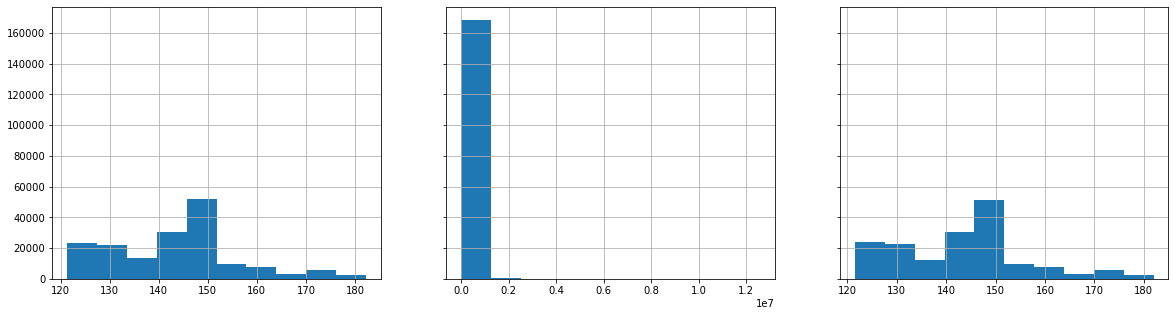

In [323]:
%matplotlib inline
col_name = 'sma_30'
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20, 5))
final_set.close.hist(ax=ax[0])
final_set.volume.hist(ax=ax[1])
final_set[col_name].hist(ax=ax[2])

<AxesSubplot:>

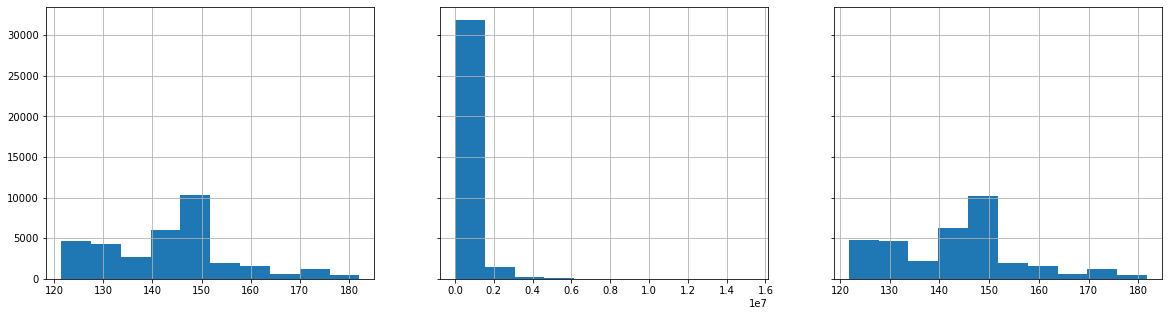

In [324]:
%matplotlib inline
col_name = 'sma_24'
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20, 5))
final_set_5min.close.hist(ax=ax[0])
final_set_5min.volume.hist(ax=ax[1])
final_set_5min[col_name].hist(ax=ax[2])

<AxesSubplot:>

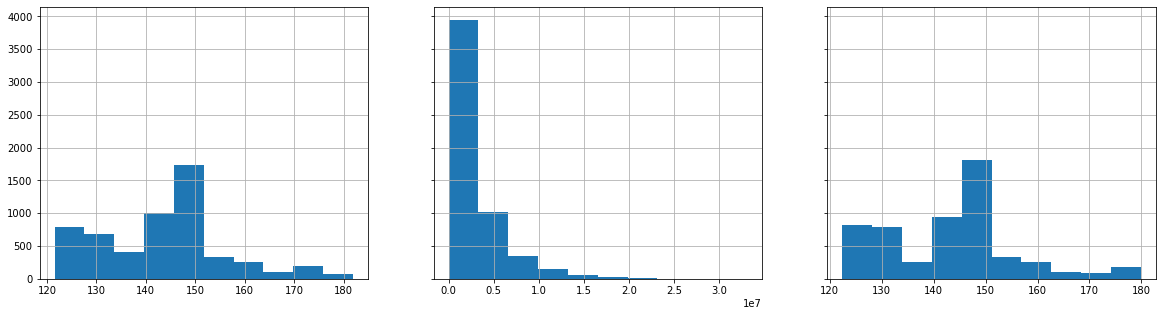

In [325]:
%matplotlib inline
col_name = 'sma_32'
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20, 5))
final_set_30min.close.hist(ax=ax[0])
final_set_30min.volume.hist(ax=ax[1])
final_set_30min[col_name].hist(ax=ax[2])

In [65]:
col_name

'sma_30'

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

final_norm_set = final_set.copy()

scaler_vol = StandardScaler()
scaler_close = MinMaxScaler()
#standard_sma = StandardScaler()

final_norm_set['volume'] = scaler_vol.fit_transform(np.array(final_norm_set['volume']).reshape(-1,1))
final_norm_set['close'] = scaler_close.fit_transform(np.array(final_norm_set['close']).reshape(-1,1))
#final_norm_set[col_name] = standard_sma.fit_transform(np.array(final_norm_set[col_name]).reshape(-1,1))

# Lets add the resulting column or the next minute price
final_norm_set['next_min'] = final_norm_set['close'].shift(-1)
# Guarantee we have all in float32 data type
for col in final_norm_set.columns:
    final_norm_set[col] = final_norm_set[col].astype('float32')
    
final_norm_set.drop(columns='sma_30', inplace=True)

final_norm_set

,market,close,volume,momentum,next_min
2021-04-12 05:00:00,-1.0,0.174908,-0.414996,-0.001859,0.174908
2021-04-12 05:01:00,-1.0,0.174908,-0.450406,-0.001081,0.174908
2021-04-12 05:02:00,-1.0,0.174908,-0.449808,-0.000302,0.175072
2021-04-12 05:03:00,-1.0,0.175072,-0.452311,-0.000025,0.175072
2021-04-12 05:04:00,-1.0,0.175072,-0.453809,0.000276,0.175072
...,...,...,...,...,...
2021-12-17 19:56:00,1.0,0.827964,-0.446684,0.006193,0.827964
2021-12-17 19:57:00,1.0,0.827964,0.273050,0.005668,0.829772
2021-12-17 19:58:00,1.0,0.829772,-0.442190,0.005222,0.829114
2021-12-17 19:59:00,1.0,0.829114,-0.448209,0.004950,0.830593


In [82]:
normal_vol.data_max_

array([12561015.])

In [83]:
final_norm_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168901 entries, 2021-04-12 05:00:00 to 2021-12-17 20:00:00
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   market    168901 non-null  float32
 1   close     168901 non-null  float32
 2   volume    168901 non-null  float32
 3   momentum  168901 non-null  float32
 4   next_min  168900 non-null  float32
dtypes: float32(5)
memory usage: 4.5+ MB


In [19]:
# Constants
###   training_size = 0.8
###   test_size = 1 - training_size
batch_size = 64
#epochs = 100
###   sequence_size = 30 #????
#average_size = 20 # For SMA data
###   model_input_size = 4
model_lstm_layers = 2
model_lstm_size = 128
model_dropout = 0.25
model_learning_rate = 0.01
model_learn_change_pos = 40
model_output = 1
###   total_size = 4800

In [84]:
# defining final arrays
def final_arrays(data, total_size, sequence_size, test_size, model_input_size):
    
    dataset = data[-total_size:].values
    total_rows = (total_size // sequence_size) * sequence_size
    total_test_rows = int(((total_rows * test_size) // sequence_size ) * sequence_size)
    total_train_rows = total_rows - total_test_rows

    train_values = dataset[-(total_train_rows+total_test_rows+1):-total_test_rows-1]
    test_values = dataset[-total_test_rows-1:-1]

    train_X, train_y = train_values[:,:-1], train_values[:,-1]
    train_batches = len(train_X) - sequence_size + 1
    train_X = np.lib.stride_tricks.as_strided(train_X.flatten(), shape=(train_batches, sequence_size, model_input_size), strides=(model_input_size*4, model_input_size*4, 4))
    train_y = train_y[sequence_size-1:]

    test_X, test_y = test_values[:,:-1], test_values[:,-1]
    test_batches = len(test_X) - sequence_size + 1
    test_X = np.lib.stride_tricks.as_strided(test_X.flatten(), shape=(test_batches, sequence_size, model_input_size), strides=(model_input_size*4, model_input_size*4, 4))
    test_y = test_y[sequence_size-1:]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # To tensors:
    train_X = torch.Tensor(train_X)
    test_X = torch.Tensor(test_X)
    train_y = torch.Tensor(train_y)
    test_y = torch.Tensor(test_y)

    return train_X, train_y, test_X, test_y

training_size = 0.8
test_size = 1 - training_size
total_size = 4800
sequence_size = 30
model_input_size = 4

train_X, train_y, test_X, test_y = final_arrays(final_norm_set, total_size, sequence_size, test_size, model_input_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


4800 4800 930 3870
(3840, 30, 4) (3840,) (901, 30, 4) (901,)
torch.Size([3840, 30, 4]) torch.Size([3840]) torch.Size([901, 30, 4]) torch.Size([901])


In [72]:
class Data_Prep(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [73]:
class ModLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2, output_size=1, drop_prob=0.2, lr=0.01):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.drop_prob = drop_prob

        self.linear = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_size, hidden_size=self.hidden_size, num_layers=self.num_layers, 
                            dropout=self.drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_end = nn.Linear(self.hidden_size*self.num_layers, self.output_size)
        
        self.init_hidden()

    def forward(self, x):
        batchsize = x.shape[0]
        x = self.linear(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        x = h_n.permute(1,0,2).reshape(batchsize, -1)
        
        x = self.dropout(x)
        out = self.linear_end(x)
        
        return out[:,-1]
    
    def init_hidden(self):
        for name, param in self.lstm.named_parameters():
            if 'bias_ih' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)


In [169]:
def train_test(model, data, criterion, opt, epochs=10, batch_size=64, seq_length=30, lr=0.001, training=True):
    
    epoch_loss = 0

    if training:
        model.train()
    else:
        model.eval()

    for x, y in data:
        if training:
            opt.zero_grad()

        batchsize = x.shape[0]
        
        out = model(x)
        loss = criterion(out, y)

        if training:
            loss.backward()
            opt.step()

        epoch_loss += (loss.detach().item() / batchsize)

    return epoch_loss
    

In [78]:
# Constants
batch_size = 64
model_lstm_layers = 2
model_lstm_size = 128
model_dropout = 0.25
model_learning_rate = 0.01
model_learn_change_pos = 40
model_output = 1
epochs = 100

In [79]:
model = ModLSTM(input_size=model_input_size, hidden_size=model_lstm_size, 
                num_layers=model_lstm_layers, output_size=model_output, drop_prob=model_dropout, 
                lr=model_learning_rate)
model

ModLSTM(
  (linear): Linear(in_features=4, out_features=128, bias=True)
  (relu): ReLU()
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_end): Linear(in_features=256, out_features=1, bias=True)
)

In [85]:
######## First test Adagrad 
##########################################################
#### group: 4800 - 1 week - without SMA
#### Optimizer = Adagrad
#### test : batch = 64, model_lstm = 128, seq = 30, layers 2, lr = 0.01

learning_rates = [0.05, 0.01, 0.005, 0.001]
optimizers = ['SGD', 'Adagrad', 'Adam']
tests = {}
test = 1

for optimizer in optimizers:
    for lr in learning_rates:
        
        train_series = Data_Prep(train_X, train_y)
        test_series = Data_Prep(test_X, test_y)

        train_dataloader = DataLoader(train_series, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_series, batch_size=batch_size, shuffle=True)
        
        model = ModLSTM(input_size=model_input_size, hidden_size=model_lstm_size, 
                num_layers=model_lstm_layers, output_size=model_output, drop_prob=model_dropout, 
                lr=lr)
        
    
        if optimizer == 'SGD':
            opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif optimizer == 'Adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimizer == 'Adagrad':
            opt = torch.optim.Adagrad(model.parameters(), lr=lr)
            
        criterion = nn.MSELoss()
        losses_training = []
        losses_testing = []
        
        print("Optimizer: {}, Leaning rate: {}".format(optimizer, lr))
        
        for epoch in range(epochs):
            loss_train = train_test(model, train_dataloader, criterion, opt, epochs=epochs, 
                                    batch_size=batch_size, seq_length=sequence_size, lr=lr)
            losses_training.append(loss_train)
            loss_test = train_test(model, test_dataloader, criterion, opt, training=False)
            losses_testing.append(loss_test)
            #scheduler.step()

            if (epoch+1)%5 == 0:
                print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                          .format(epoch+1, epochs, loss_train, loss_test))

        tests['test-'+str(test)] = {'opt' : optimizer,
                                    'lr' : lr,
                                    'training' : losses_training,
                                    'testing' : losses_testing,
                                    'min_train' : np.array(losses_training).min(),# the last not the minimum
                                    'min_test' : np.array(losses_testing).min()} # the last not the minimum
        test += 1
        
        print('minimo train: ', np.array(losses_training).min())
        print('minimo test: ', np.array(losses_testing).min())

Optimizer: SGD, Leaning rate: 0.05
Epoch[5/100] | loss train:0.001598, test:0.001565
Epoch[10/100] | loss train:0.001030, test:0.000955
Epoch[15/100] | loss train:0.000603, test:0.000462
Epoch[20/100] | loss train:0.000434, test:0.000202
Epoch[25/100] | loss train:0.000316, test:0.000237
Epoch[30/100] | loss train:0.000259, test:0.000122
Epoch[35/100] | loss train:0.000212, test:0.000108
Epoch[40/100] | loss train:0.000178, test:0.000058
Epoch[45/100] | loss train:0.000158, test:0.000042
Epoch[50/100] | loss train:0.000147, test:0.000030
Epoch[55/100] | loss train:0.000135, test:0.000010
Epoch[60/100] | loss train:0.000129, test:0.000050
Epoch[65/100] | loss train:0.000119, test:0.000023
Epoch[70/100] | loss train:0.000114, test:0.000065
Epoch[75/100] | loss train:0.000104, test:0.000047
Epoch[80/100] | loss train:0.000106, test:0.000056
Epoch[85/100] | loss train:0.000098, test:0.000021
Epoch[90/100] | loss train:0.000098, test:0.000019
Epoch[95/100] | loss train:0.000089, test:0.0000

<AxesSubplot:>

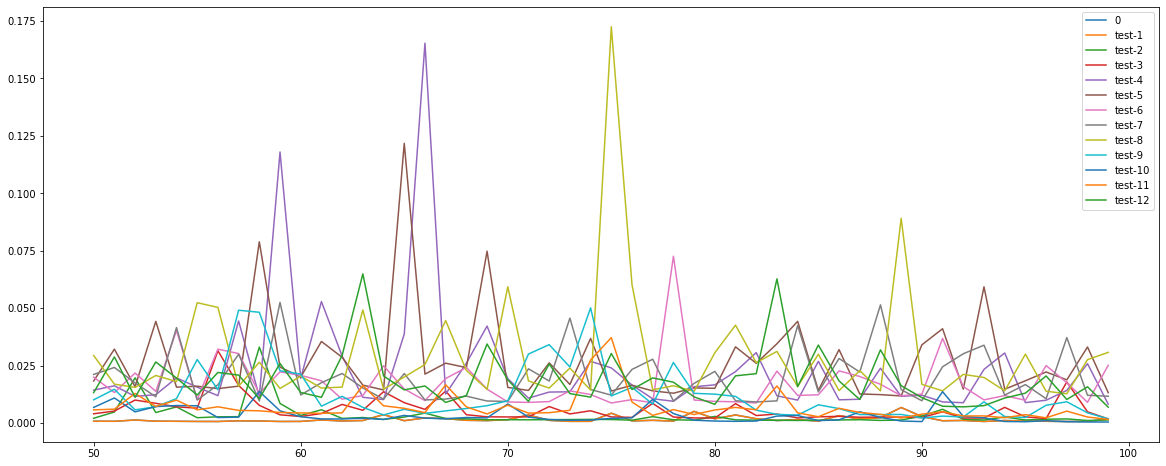

In [196]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL TRAINS'''

<AxesSubplot:title={'center':'ALL TRAINS - THREE OPTIMIZERS'}>

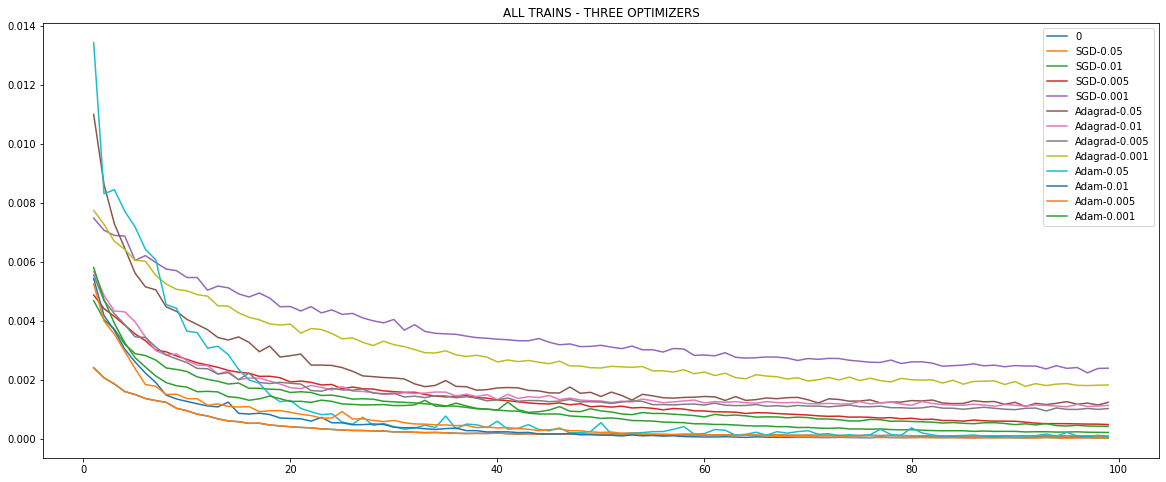

In [93]:
df = pd.DataFrame(tests)
graphs = pd.DataFrame(df.loc['training','test-1'])
for test in tests.keys():
    graphs[test] = pd.DataFrame(df.loc['training',test])
graphs.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                       'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                       'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, inplace=True)
graphs.loc[1:].plot(title='ALL TRAINS - THREE OPTIMIZERS',figsize=(20,8))

In [191]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''df'''

,test-1,test-2,test-3,test-4,test-5,test-6,test-7,test-8,test-9,test-10,test-11,test-12
opt,SGD,SGD,SGD,SGD,Adagrad,Adagrad,Adagrad,Adagrad,Adam,Adam,Adam,Adam
lr,0.05,0.01,0.005,0.001,0.05,0.01,0.005,0.001,0.05,0.01,0.005,0.001
training,"[0.42291469138581306, 0.016681604138284456, 0....","[0.3810718290624209, 0.053501337199122645, 0.0...","[0.5396542101516388, 0.10609309485880658, 0.07...","[0.6181836150935851, 0.09559851553058252, 0.08...","[0.8879201991367154, 0.09372270165476948, 0.07...","[0.23632764612557366, 0.06217170716263354, 0.0...","[0.28196491263224743, 0.10436635436781216, 0.0...","[0.4496695769485086, 0.09442880720598623, 0.04...","[2.050059132045135, 0.24530845950357616, 0.115...","[0.39588949538301677, 0.4456645940663293, 0.07...","[0.22394509211881086, 0.05390823175548576, 0.0...","[0.5927011162857525, 0.1095378531026654, 0.046..."
testing,"[0.05409295030403882, 0.0005638039816403762, 0...","[0.038911074749194086, 0.012515242892550304, 0...","[0.04339145477861166, 0.022621877735946327, 0....","[0.030652076099067928, 0.03848653628956526, 0....","[0.13549944451078771, 0.11925256354734301, 0.0...","[0.016969992552185433, 0.061704697506502273, 0...","[0.04956018768716604, 0.06357926172204316, 0.0...","[0.06819333829917014, 0.01248584598652087, 0.0...","[0.00602623766171746, 0.06939901122823358, 0.0...","[0.055453002406284216, 0.11315005645155907, 0....","[0.05489964266307652, 0.0016613339481409638, 0...","[0.04436447157058865, 0.03680960470810533, 0.0..."
min_train,0.000615003,0.00104816,0.00173565,0.00816231,0.0117475,0.00868551,0.00913959,0.0127096,0.00177701,0.00038525,0.00154698,0.0068652
min_test,5.03346e-05,9.2978e-05,0.00011457,0.000152257,6.34939e-05,6.18679e-05,9.40087e-05,0.000209948,0.000446978,6.2231e-05,8.06691e-05,7.92654e-05


In [98]:
df.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                       'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                       'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, inplace=True)
df

,SGD-0.05,SGD-0.01,SGD-0.005,SGD-0.001,Adagrad-0.05,Adagrad-0.01,Adagrad-0.005,Adagrad-0.001,Adam-0.05,Adam-0.01,Adam-0.005,Adam-0.001
opt,SGD,SGD,SGD,SGD,Adagrad,Adagrad,Adagrad,Adagrad,Adam,Adam,Adam,Adam
lr,0.05,0.01,0.005,0.001,0.05,0.01,0.005,0.001,0.05,0.01,0.005,0.001
training,"[0.04529535208348534, 0.0024063066812232137, 0...","[0.05452969185716938, 0.0046787135433987714, 0...","[0.06336273385386448, 0.004870231492532184, 0....","[0.10757488952367567, 0.007475744241673965, 0....","[1.1248791309335502, 0.010990125927492045, 0.0...","[0.06029178863536799, 0.005669401103659766, 0....","[0.021744152712926734, 0.0055446289261453785, ...","[0.04815073447389295, 0.007736351573839784, 0....","[1.0979262111941352, 0.013421851966995746, 0.0...","[0.07447329213755438, 0.005423191589216003, 0....","[0.036444342047616374, 0.005244250984105747, 0...","[0.03255719984008465, 0.005797587364213541, 0...."
testing,"[0.004118894462590106, 0.0015733538282802328, ...","[0.003990314318798482, 0.0019942668979638254, ...","[0.002478850356419571, 0.0020641056122258305, ...","[0.0009372660177177749, 0.0018684668561036234,...","[0.0021917314268648626, 0.0013757668632024434,...","[0.002702959705493413, 0.002483456366462633, 0...","[0.002954778794082813, 0.0019374705225345679, ...","[0.0038654487478197554, 0.0025064867193577813,...","[0.009702169592492283, 0.0007713774393778294, ...","[0.003196137498889584, 0.0033995477846474388, ...","[0.0020522272847301793, 0.0023178595467470585,...","[0.0016906189041037579, 0.0023137525844504126,..."
min_train,8.40856e-05,0.000211616,0.00048177,0.00223185,0.00109126,0.00108257,0.000940294,0.00177514,7.56302e-05,2.72908e-05,2.29912e-05,0.000418735
min_test,1.01527e-05,3.03859e-05,0.000113165,0.000937266,2.98434e-05,1.03934e-05,1.02113e-05,0.000121242,5.84762e-06,6.2307e-06,5.10877e-06,5.69948e-06


<AxesSubplot:>

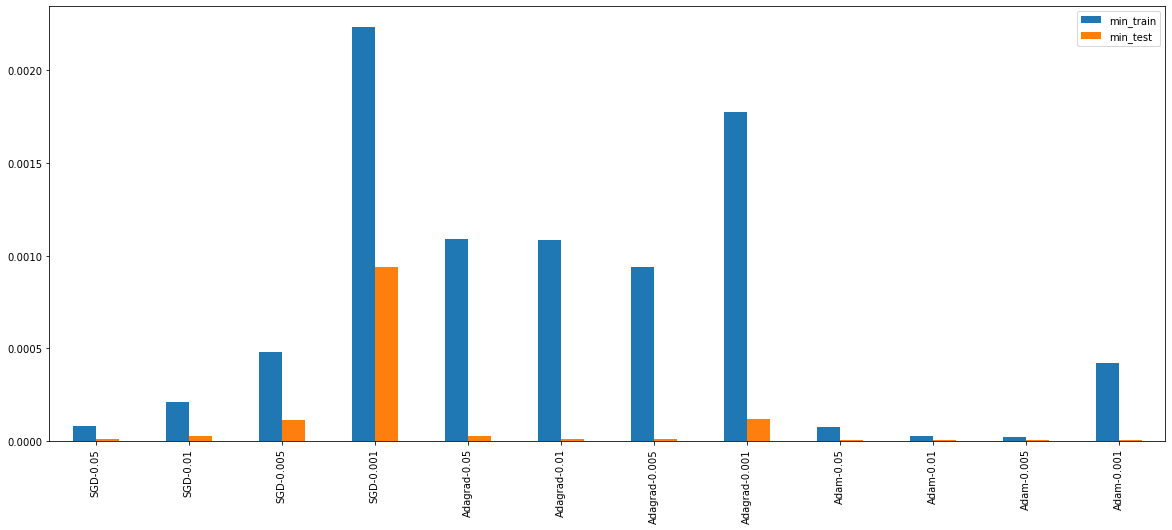

In [106]:
df.T.loc[:,'min_train':'min_test'].plot(figsize=(20,8), kind='bar')

<AxesSubplot:>

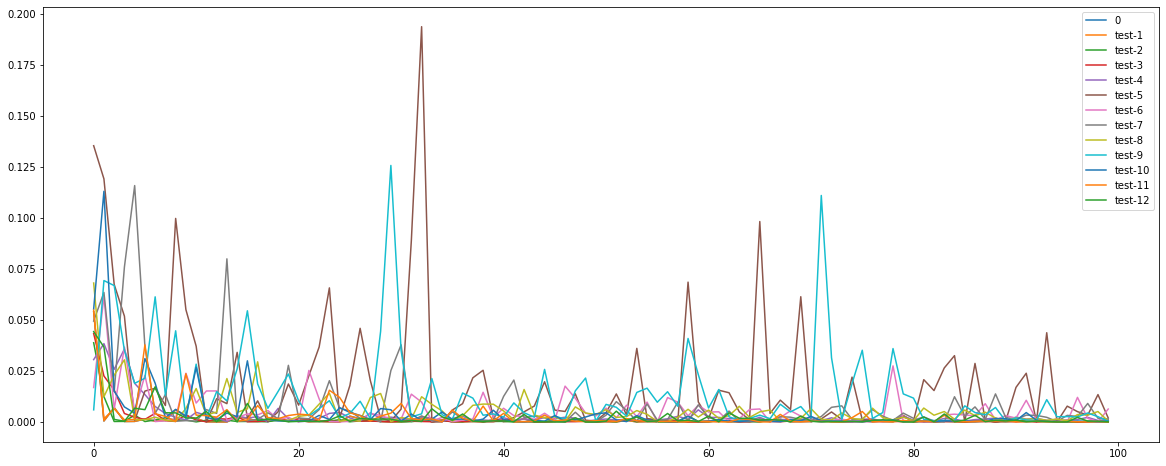

In [207]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL TESTS'''


<AxesSubplot:title={'center':'ALL TESTS - THREE OPTIMIZERS'}>

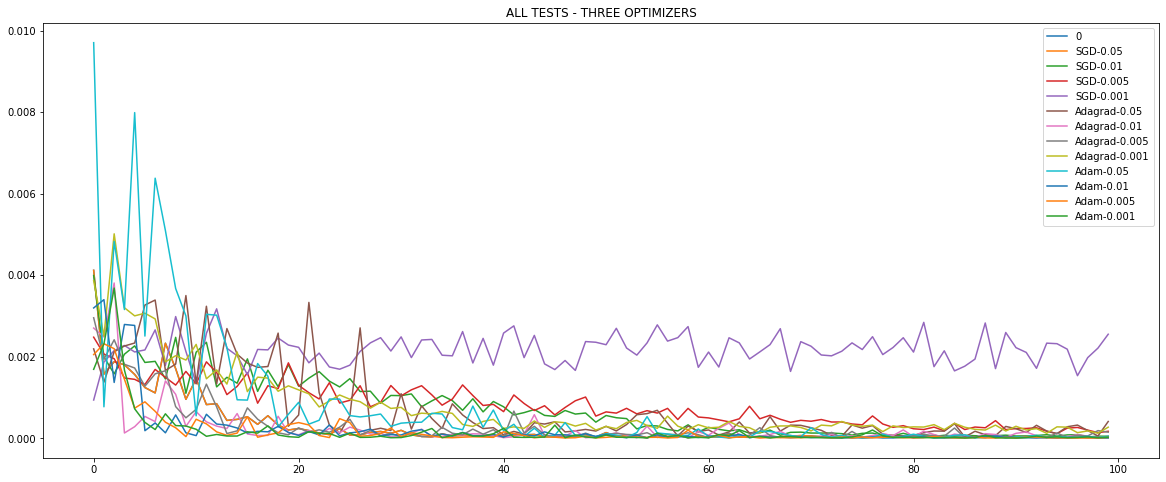

In [108]:
df = pd.DataFrame(tests)
graphs_test = pd.DataFrame(df.loc['testing','test-1'])
for test in tests.keys():
    graphs_test[test] = pd.DataFrame(df.loc['testing',test])
graphs_test.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                       'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                       'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, inplace=True)
graphs_test.loc[:].plot(title='ALL TESTS - THREE OPTIMIZERS', figsize=(20,8))

<AxesSubplot:>

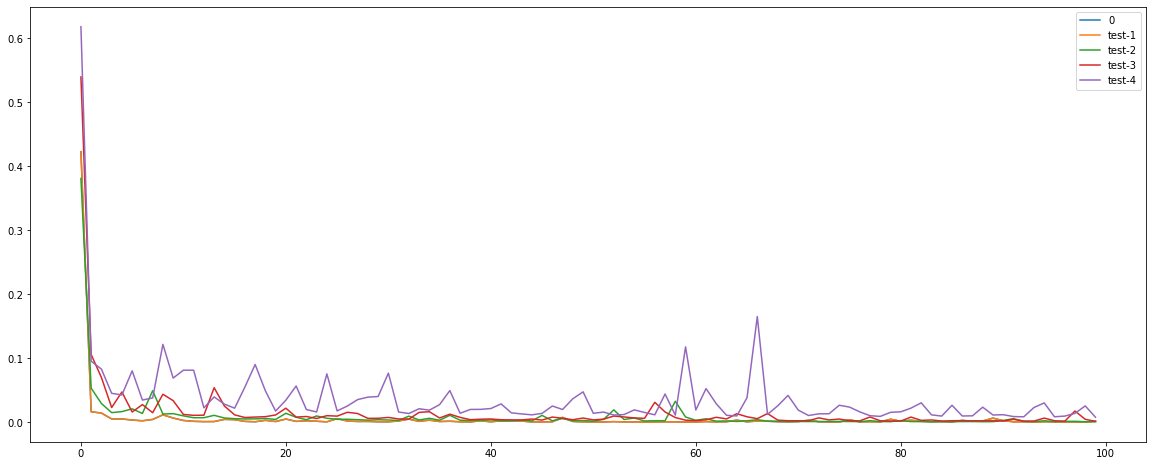

In [213]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL SGD TRAINS'''


<AxesSubplot:title={'center':'SGD OPTIMIZER - TRAINS'}>

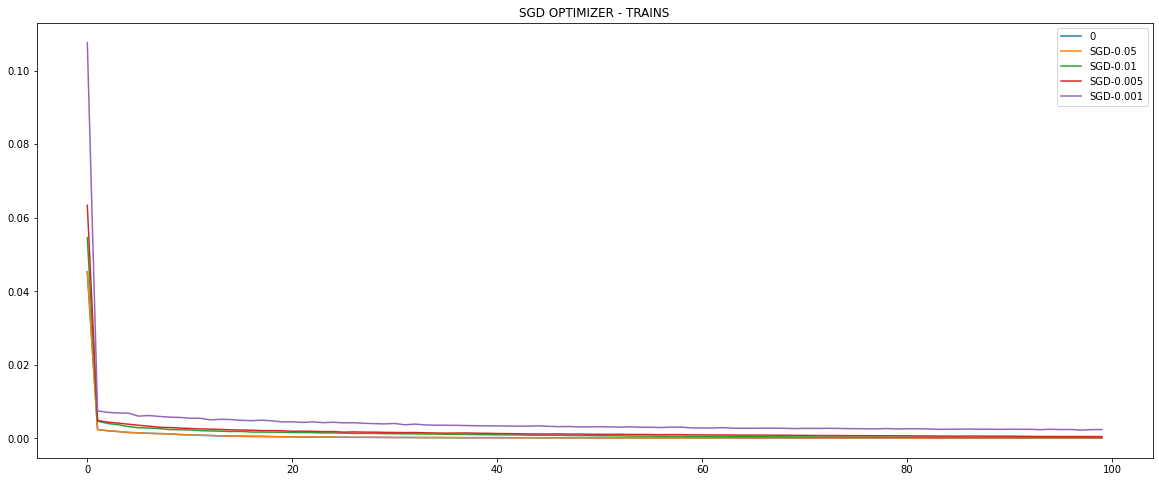

In [109]:
###SGD trains
graphs.iloc[:,:5].plot(title='SGD OPTIMIZER - TRAINS', figsize=(20,8))

<AxesSubplot:>

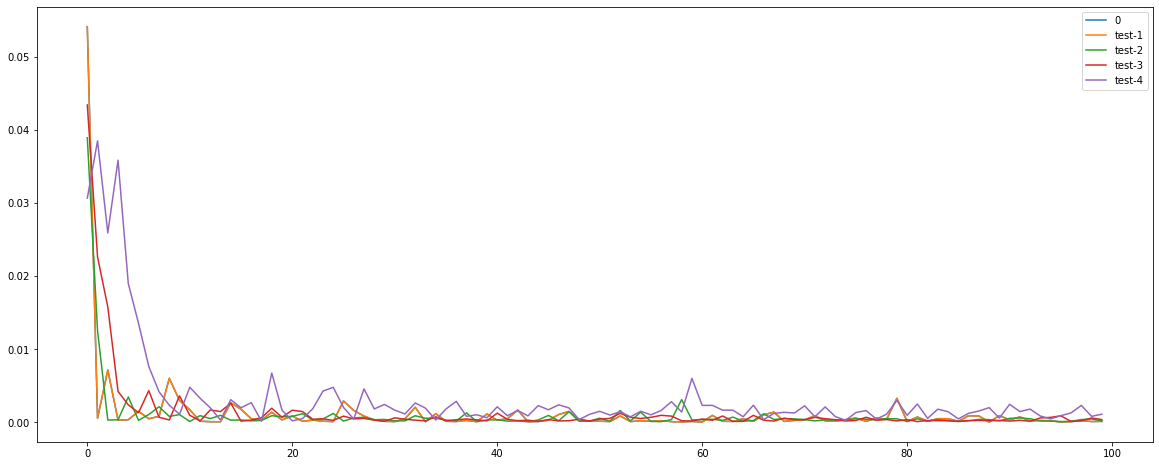

In [210]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL SGD TESTS'''


<AxesSubplot:title={'center':'SGD OPTIMIZER - TESTS'}>

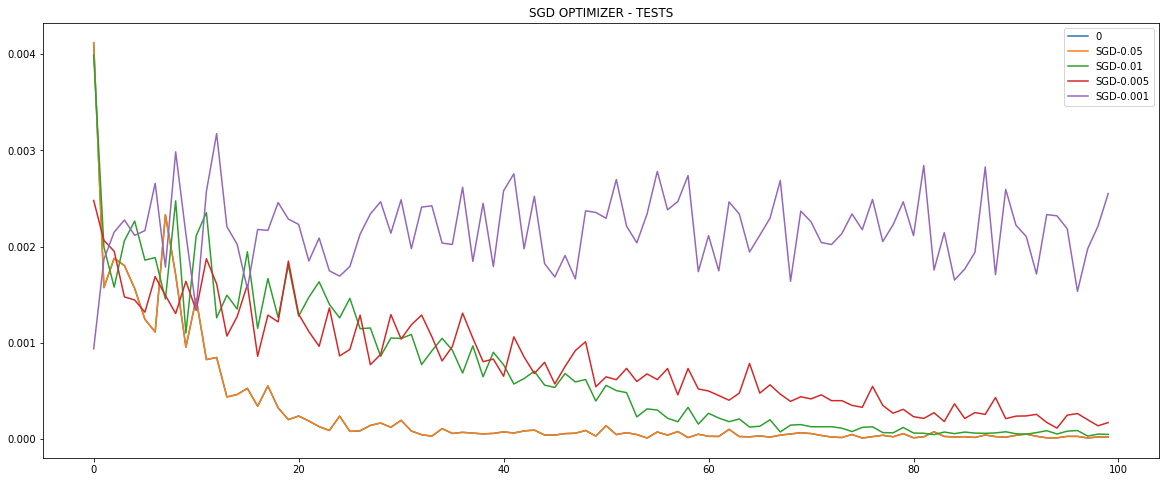

In [110]:
###SGD tests
graphs_test.iloc[:,:5].plot(title='SGD OPTIMIZER - TESTS', figsize=(20,8))

<AxesSubplot:>

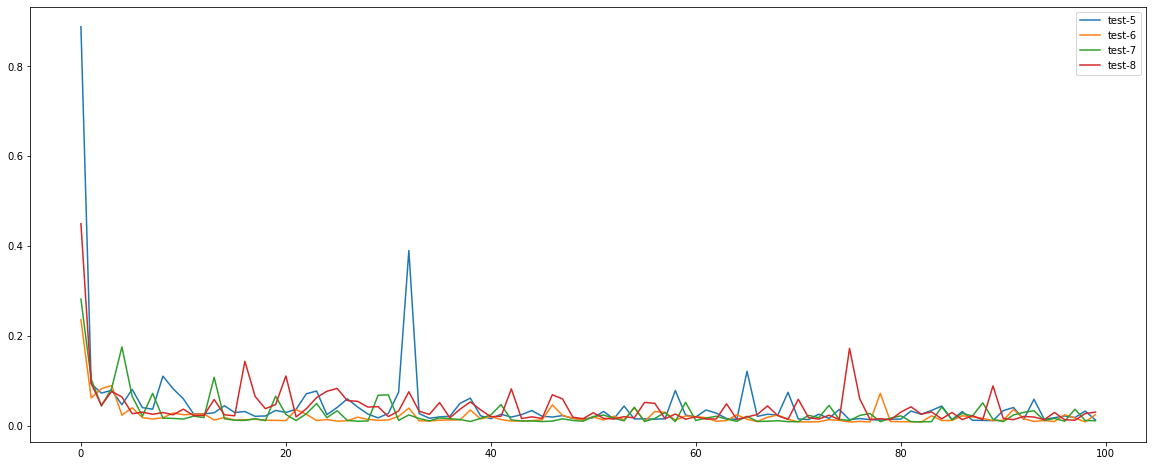

In [214]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAGRAD TRAINS'''


<AxesSubplot:title={'center':'ADAGRAD OPTIMIZER - TRAINS'}>

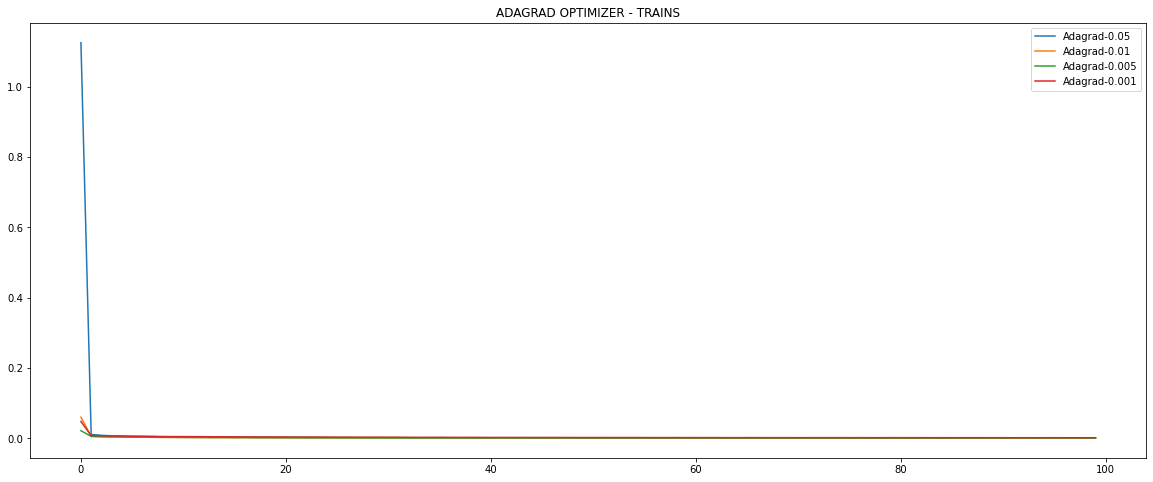

In [111]:
###Adagrad trains
graphs.iloc[:,5:9].plot(title='ADAGRAD OPTIMIZER - TRAINS', figsize=(20,8))

<AxesSubplot:>

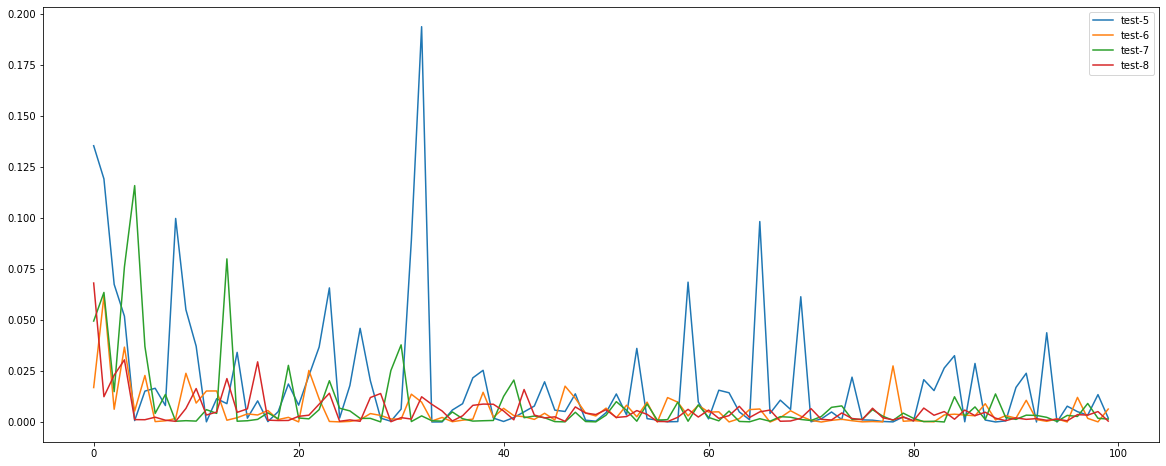

In [211]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAGRAD TESTS'''


<AxesSubplot:title={'center':'ADAGRAD OPTIMIZER - TESTS'}>

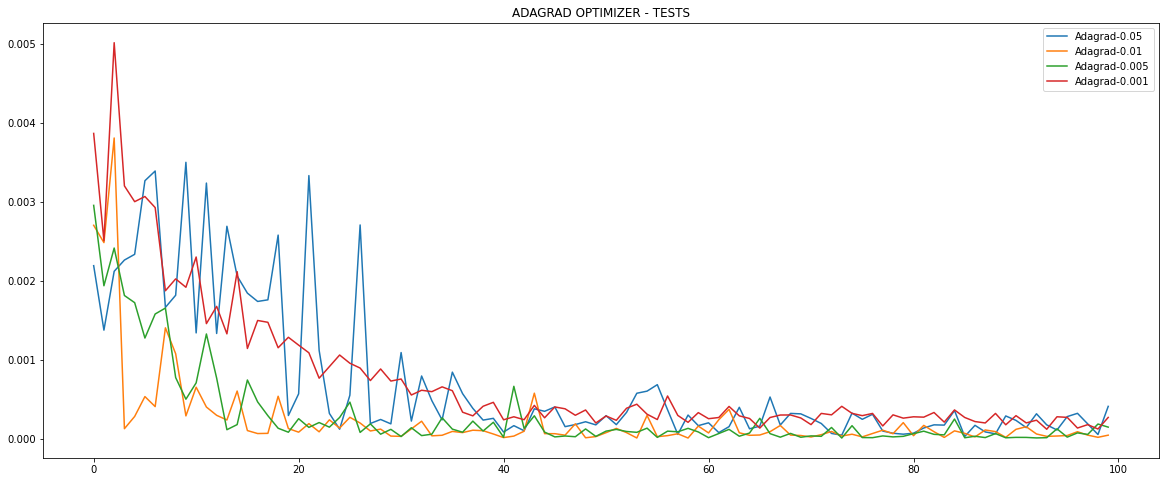

In [112]:
###Adagrad tests
graphs_test.iloc[:,5:9].plot(title='ADAGRAD OPTIMIZER - TESTS', figsize=(20,8))

<AxesSubplot:>

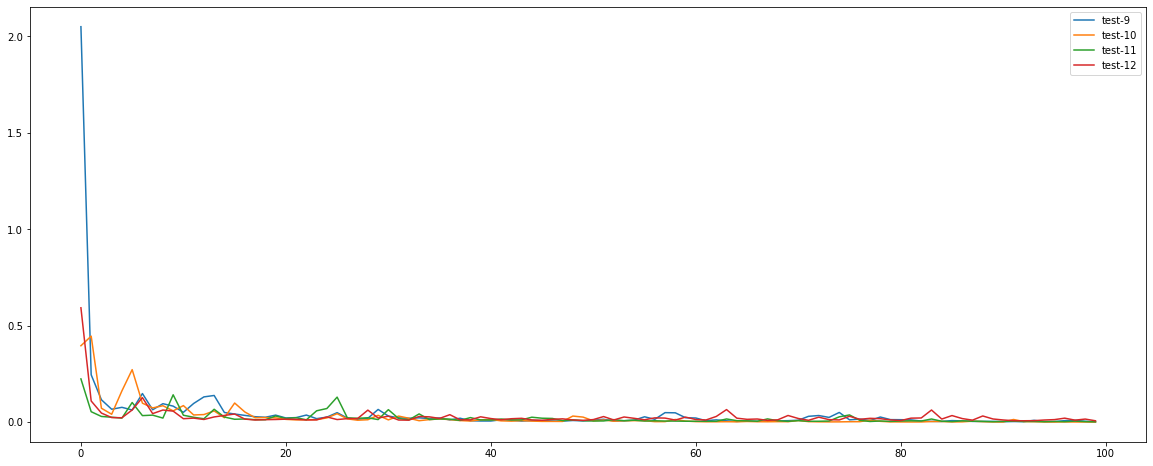

In [215]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAM TRAINS'''


<AxesSubplot:title={'center':'ADAM OPTIMIZER - TRAINS'}>

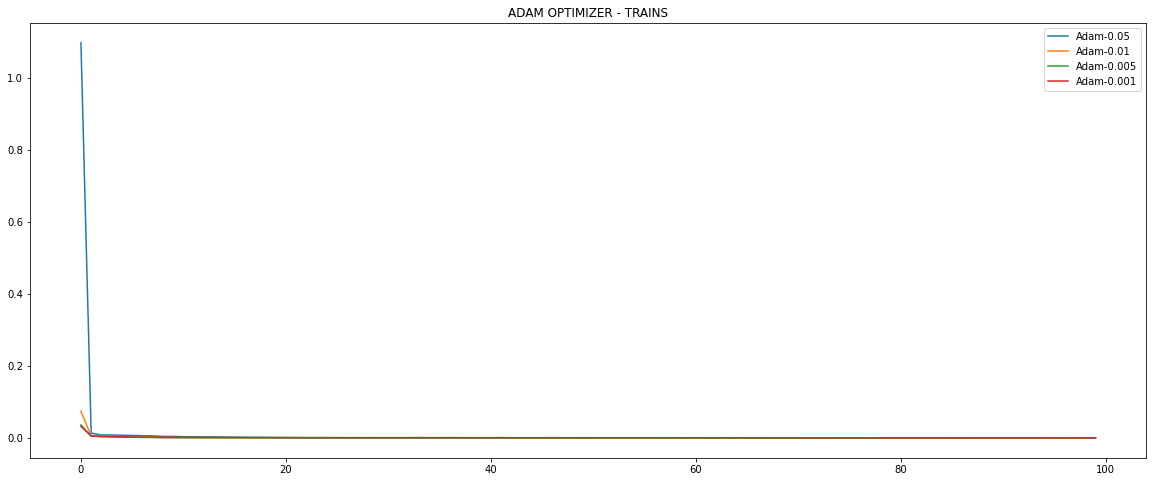

In [113]:
###Adam trains
graphs.iloc[:,9:13].plot(title='ADAM OPTIMIZER - TRAINS', figsize=(20,8))

<AxesSubplot:>

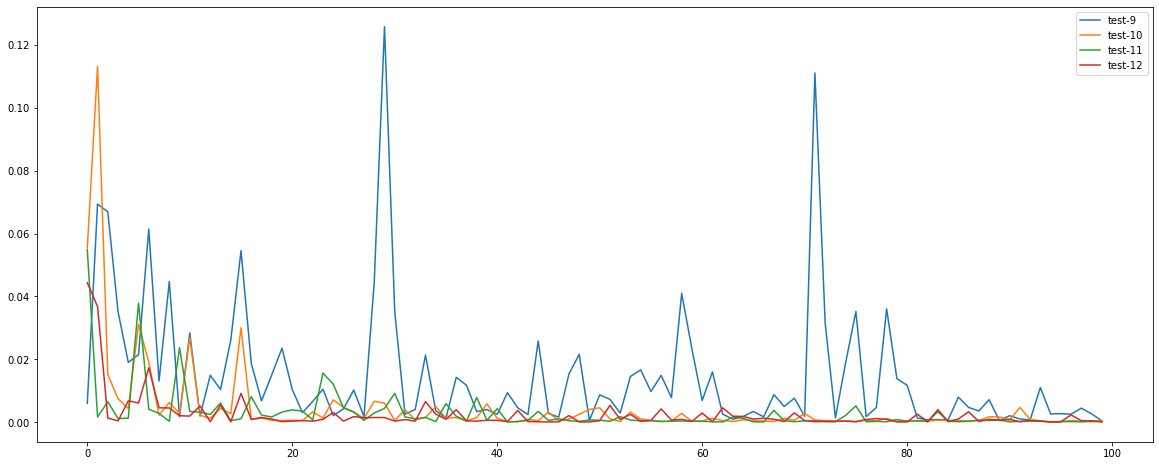

In [212]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAM TESTS'''


<AxesSubplot:title={'center':'ADAM OPTIMIZER - TESTS'}>

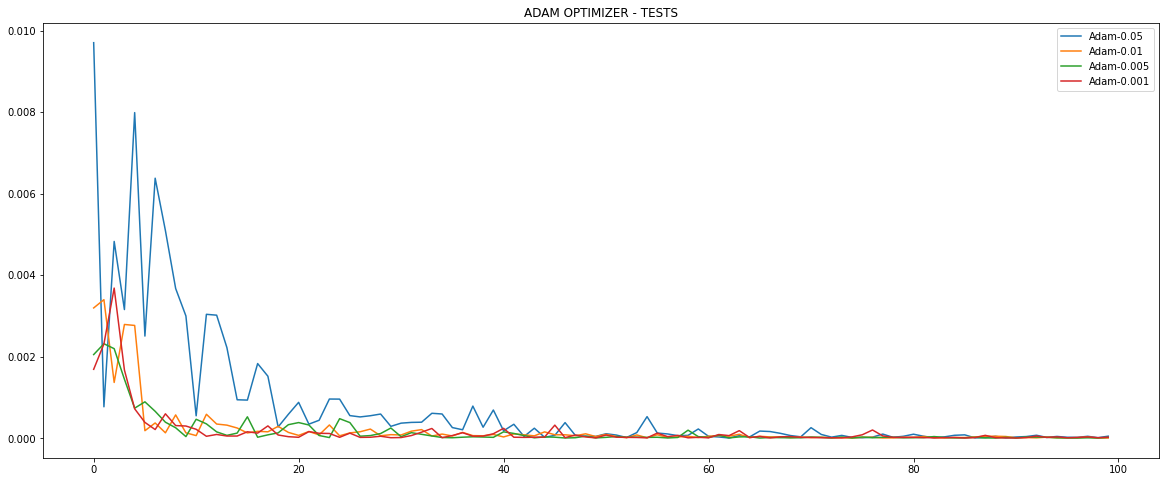

In [114]:
###Adam tests
graphs_test.iloc[:,9:13].plot(title='ADAM OPTIMIZER - TESTS', figsize=(20,8))

In [ ]:
### Adam it is. And we will start with lr of 0.005, later we will try with different learning rates.
### We'll do this time 200 epochs.
### We will try with the data for two days, meaning 9600 minutes of data.

In [186]:
######## Final approach Adam and lr=0.01

def training_model(train_X, train_y, test_X, test_y,
                   batch_size=64, model_input_size=4, model_lstm_size=128,
                   model_lstm_layers=2, model_output=1, model_dropout=0.25,
                   optimizer='Adam', lr=0.005, epochs=200, sequence_size=30, 
                   lr_change=False, lr_top=0.001, epochs_top=150):

    train_series = Data_Prep(train_X, train_y)
    test_series = Data_Prep(test_X, test_y)
    
    train_dataloader = DataLoader(train_series, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_series, batch_size=batch_size, shuffle=True)
    
    model = ModLSTM(input_size=model_input_size, hidden_size=model_lstm_size, 
            num_layers=model_lstm_layers, output_size=model_output, drop_prob=model_dropout, 
            lr=lr)


    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'Adagrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    losses_training = []
    losses_testing = []

    print("Optimizer: {}, Leaning rate: {}".format(optimizer, lr))

    for epoch in range(epochs):
        
        if lr_change and (epoch > epochs_top):
            opt.param_groups[0]['lr'] = lr_top

        loss_train = train_test(model, train_dataloader, criterion, opt, epochs=epochs, 
                                batch_size=batch_size, seq_length=sequence_size, lr=lr)
        losses_training.append(loss_train)
        loss_test = train_test(model, test_dataloader, criterion, opt, training=False)
        losses_testing.append(loss_test)

        if (epoch+1)%10 == 0:
            print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}, learning rate: {}'
                  .format(epoch+1, epochs, loss_train, loss_test, opt.param_groups[0]['lr']))

    print('minimo train: ', np.array(losses_training).min())
    print('minimo test: ', np.array(losses_testing).min())
        
    return model, losses_training, losses_testing


In [177]:
total_size = 9600

train_X, train_y, test_X, test_y = final_arrays(final_norm_set, total_size, sequence_size, test_size, model_input_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model, losses_training, losses_testing = training_model(train_X, train_y, test_X, test_y, 
                                                        batch_size=64, model_input_size=4, model_lstm_size=128,
                                                        model_lstm_layers=2, model_output=1, model_dropout=0.25,
                                                        optimizer='Adam', lr=0.005, epochs=200, sequence_size=30)


9600 9600 1890 7710
(7680, 30, 4) (7680,) (1861, 30, 4) (1861,)
torch.Size([7680, 30, 4]) torch.Size([7680]) torch.Size([1861, 30, 4]) torch.Size([1861])
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/200] | loss train:0.001928, test:0.000270
Epoch[20/200] | loss train:0.000885, test:0.000220
Epoch[30/200] | loss train:0.000351, test:0.000167
Epoch[40/200] | loss train:0.000122, test:0.000024
Epoch[50/200] | loss train:0.000072, test:0.000014
Epoch[60/200] | loss train:0.000081, test:0.000009
Epoch[70/200] | loss train:0.000110, test:0.000061
Epoch[80/200] | loss train:0.000058, test:0.000021
Epoch[90/200] | loss train:0.000057, test:0.000015
Epoch[100/200] | loss train:0.000056, test:0.000011
Epoch[110/200] | loss train:0.000048, test:0.000009
Epoch[120/200] | loss train:0.000045, test:0.000018
Epoch[130/200] | loss train:0.000061, test:0.000013
Epoch[140/200] | loss train:0.000047, test:0.000006
Epoch[150/200] | loss train:0.000042, test:0.000007
Epoch[160/200] | loss train:0.000052, 

<AxesSubplot:>

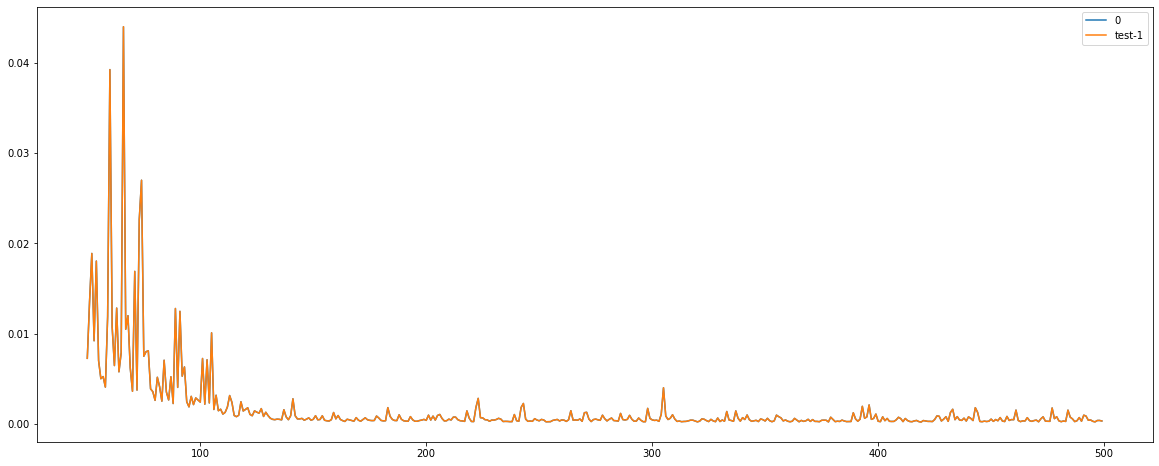

In [218]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAM TRAINS IN 500 EPOCHS'''

<AxesSubplot:>

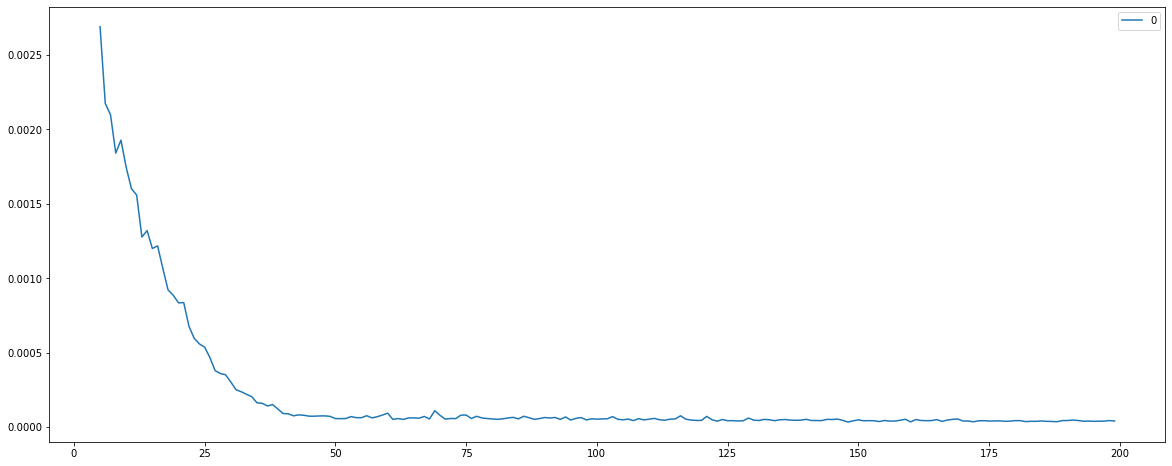

In [182]:
## Adam with 200 epochs and volume scaled as normal distribution an close prices as a linear normalization
graphs_Adam = pd.DataFrame(losses_training)
graphs_Adam.loc[5:].plot(figsize=(20,8))

In [178]:
np.array(losses_training)[-1]

4.096247629803429e-05

<AxesSubplot:>

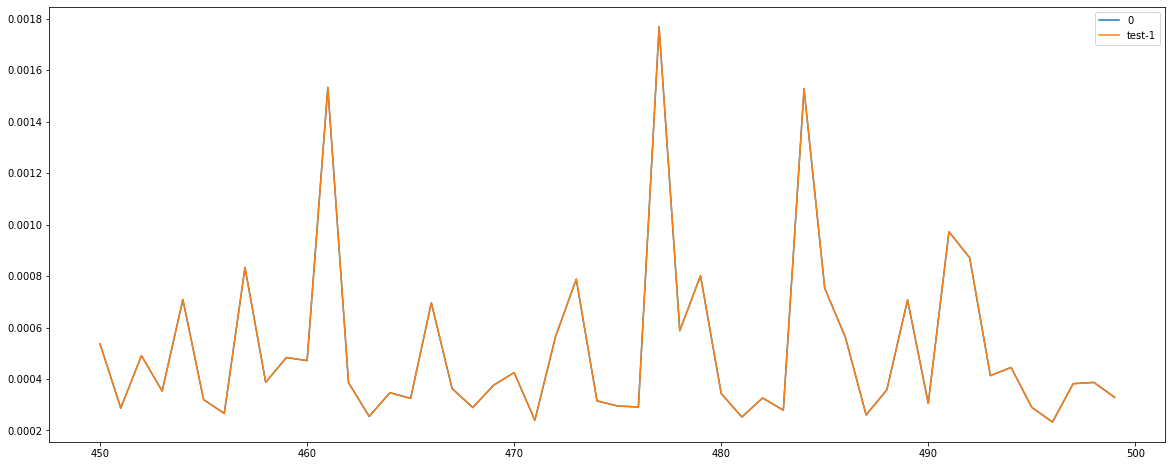

In [223]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAM TRAINS'''

<AxesSubplot:>

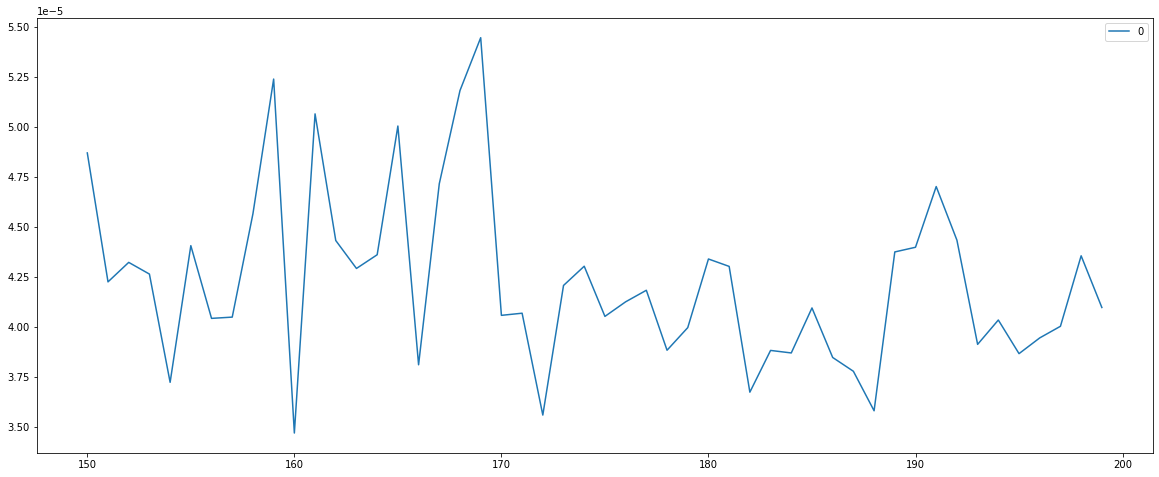

In [183]:
## Similar graphs for the final steps but with a lot smaller error range.
graphs_Adam.loc[150:].plot(figsize=(20,8))

<AxesSubplot:>

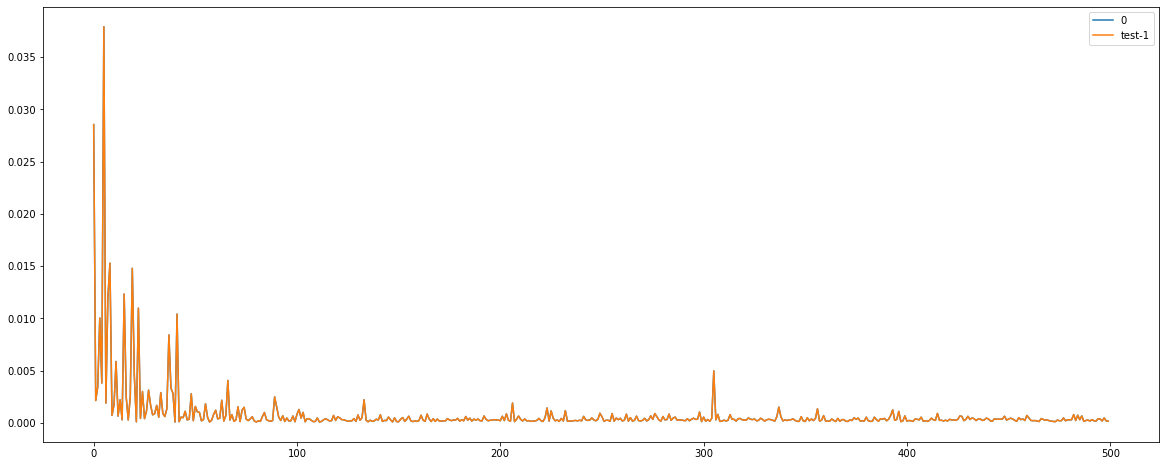

In [225]:
#### Results with standardizing the close price and normalizing the volume
'''DON'T RUN THIS CELL TO NOT ERASE THE GRAPH'''
'''ALL ADAM TRAINS'''

<AxesSubplot:>

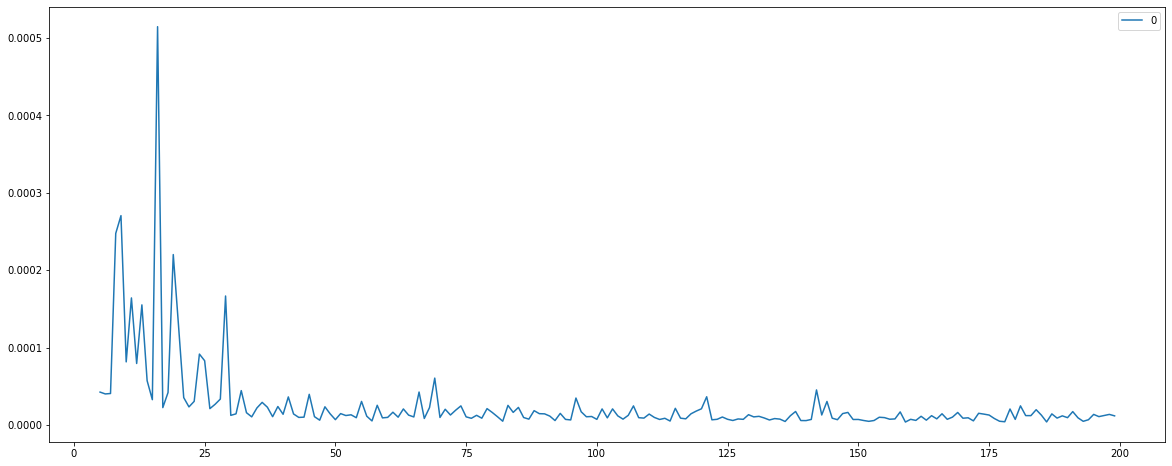

In [184]:
## Adam tests with 200 epochs and volume scaled as normal distribution an close prices as a linear normalization
graphs_Adam_test = pd.DataFrame(losses_testing)
graphs_Adam_test.loc[5:].plot(figsize=(20,8))
# Looks similar but with smaller errors.

In [188]:
# Fianl aproach with 
model_lstm_layers = 3
model_dropout = 0.3
second_lr = 0.001
changing_epoch = 150

model_f, losses_training_f, losses_testing_f = training_model(train_X, train_y, test_X, test_y, 
                                                        batch_size=64, model_input_size=4, model_lstm_size=128,
                                                        model_lstm_layers=model_lstm_layers, model_output=1, model_dropout=model_dropout,
                                                        optimizer='Adam', lr=0.005, epochs=200, sequence_size=30,
                                                        lr_change=True, lr_top=second_lr, epochs_top=changing_epoch)

Optimizer: Adam, Leaning rate: 0.005
Epoch[10/200] | loss train:0.001640, test:0.000095, learning rate: 0.005
Epoch[20/200] | loss train:0.000672, test:0.000028, learning rate: 0.005
Epoch[30/200] | loss train:0.000247, test:0.000013, learning rate: 0.005
Epoch[40/200] | loss train:0.000094, test:0.000012, learning rate: 0.005
Epoch[50/200] | loss train:0.000091, test:0.000100, learning rate: 0.005
Epoch[60/200] | loss train:0.000075, test:0.000008, learning rate: 0.005
Epoch[70/200] | loss train:0.000068, test:0.000007, learning rate: 0.005
Epoch[80/200] | loss train:0.000066, test:0.000005, learning rate: 0.005
Epoch[90/200] | loss train:0.000063, test:0.000009, learning rate: 0.005
Epoch[100/200] | loss train:0.000062, test:0.000009, learning rate: 0.005
Epoch[110/200] | loss train:0.000063, test:0.000020, learning rate: 0.005
Epoch[120/200] | loss train:0.000046, test:0.000004, learning rate: 0.005
Epoch[130/200] | loss train:0.000048, test:0.000013, learning rate: 0.005
Epoch[140/

<AxesSubplot:>

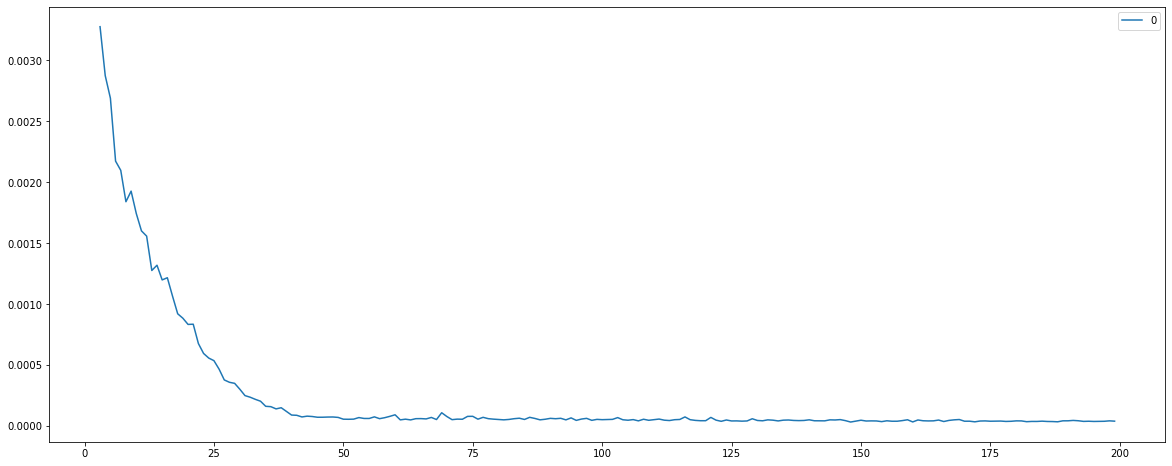

In [190]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_2xlr = pd.DataFrame(losses_training)
graphs_Adam_2xlr.loc[3:].plot(figsize=(20,8))

<AxesSubplot:>

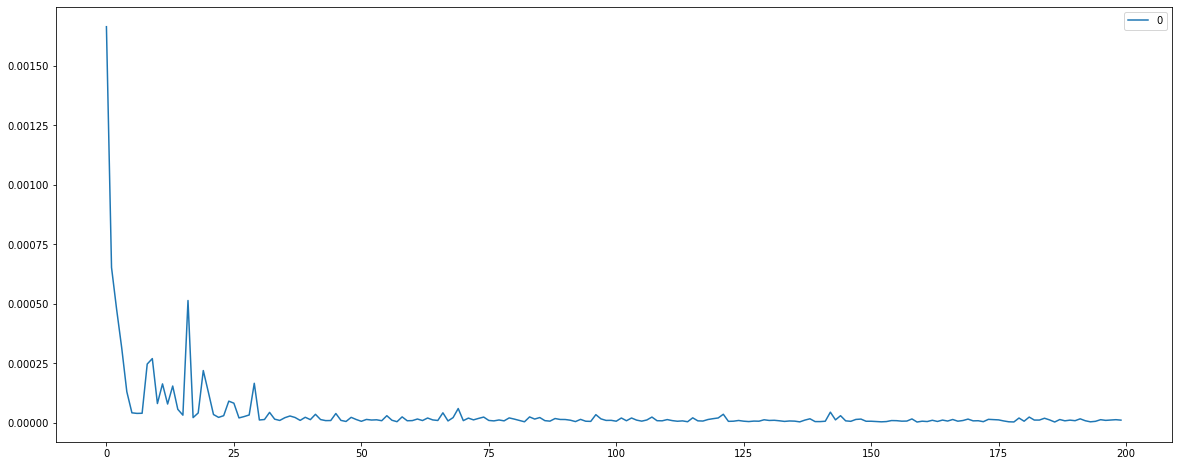

In [191]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_test_2xlr = pd.DataFrame(losses_testing)
graphs_Adam_test_2xlr.loc[:].plot(figsize=(20,8))

In [192]:
### Saving the model
path = '/Users/carlosarocha/Dropbox/AI/GITHUB/UDACITY/TRADING_AI/My_Trading_Library/stock_predicting_model_1minute.dat'
torch.save(model_f, path)

In [193]:
### Loading the model
path = '/Users/carlosarocha/Dropbox/AI/GITHUB/UDACITY/TRADING_AI/My_Trading_Library/stock_predicting_model_1minute.dat'
model_f = torch.load(path)

In [199]:
# Preparing all the data to predict and graph
def data_to_predict(data, total_size, sequence_size, model_input_size):

    total_rows = (total_size // sequence_size) * sequence_size
    total_test_rows = int(((total_rows * test_size) // sequence_size ) * sequence_size)
    total_train_rows = total_rows - total_test_rows

    all_values = data.values[-(total_train_rows+total_test_rows+1):-1]
    batches_to_predict = len(all_values) - sequence_size + 1
    x, y = all_values[:,:-1], all_values[:,-1]
    x = np.lib.stride_tricks.as_strided(x.flatten(), 
                                        shape=(batches_to_predict, 
                                               sequence_size, model_input_size), 
                                               strides=(model_input_size * 4, model_input_size * 4, 4))
    y = y[sequence_size-1:]
    
    return x, y

x_to_predict, y_to_predict = data_to_predict(final_norm_set, total_size, sequence_size, model_input_size)
print(x_to_predict.shape, y_to_predict.shape)

(9571, 30, 4) (9571,)


In [200]:
predicting_series = Data_Prep(x_to_predict, y_to_predict)
# Restarting the dataloader with shuffle in False to have all the data in one sequence
dataloader_to_predict = DataLoader(predicting_series, batch_size=batch_size, shuffle=False)
# Now iterate for the data and check the predicted values
results = np.array([[],[]])
for x, y in dataloader_to_predict:
    y_predicted = model_f(x)
    results = np.concatenate((results, np.array([y.detach().numpy(), y_predicted.detach().numpy()])), axis = 1)
    
df = pd.DataFrame(results.T, columns=['Real', 'Predicted'])
df['Predicted'] = df['Predicted'].shift(-1)
df

,Real,Predicted
0,0.704236,0.704372
1,0.702429,0.702882
2,0.699307,0.700258
3,0.703415,0.704590
4,0.699307,0.700420
...,...,...
9566,0.827964,0.828731
9567,0.827964,0.827605
9568,0.829772,0.830263
9569,0.829114,0.829839


In [201]:
df['close'] = scaler_close.inverse_transform(np.array(df['Real']).reshape(-1,1))
df['close_predicted'] = scaler_close.inverse_transform(np.array(df['Predicted']).reshape(-1,1))
df

,Real,Predicted,close,close_predicted
0,0.704236,0.704372,164.199999,164.208241
1,0.702429,0.702882,164.089998,164.117607
2,0.699307,0.700258,163.900001,163.957878
3,0.703415,0.704590,164.150001,164.221510
4,0.699307,0.700420,163.900001,163.967737
...,...,...,...,...
9566,0.827964,0.828731,171.730001,171.776651
9567,0.827964,0.827605,171.730001,171.708153
9568,0.829772,0.830263,171.840002,171.869918
9569,0.829114,0.829839,171.800001,171.844133


<AxesSubplot:>

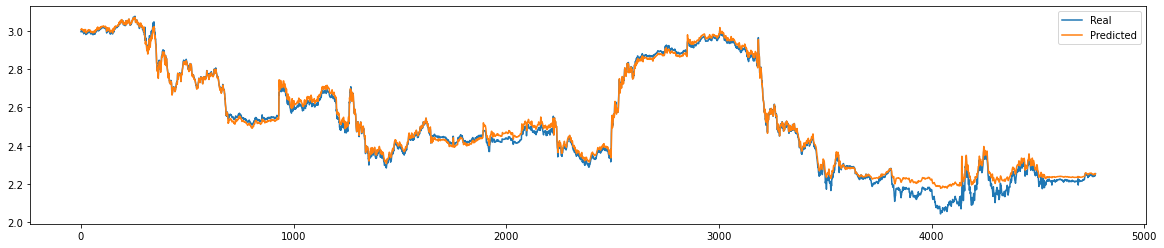

In [160]:
### This are the graphs before fixing the scaling issue.
''' DON'T RUN THIS CELL TO AVOID ERASE THE GRAPH'''
df.drop(columns=['close','close_predicted'])[:].plot(figsize=(20,4))

<AxesSubplot:>

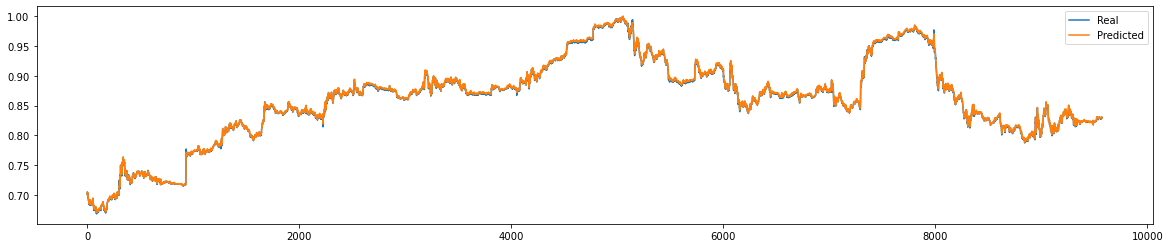

In [202]:
# The new graph with the scaler fixed
df.drop(columns=['close','close_predicted'])[:].plot(figsize=(20,4))

<AxesSubplot:>

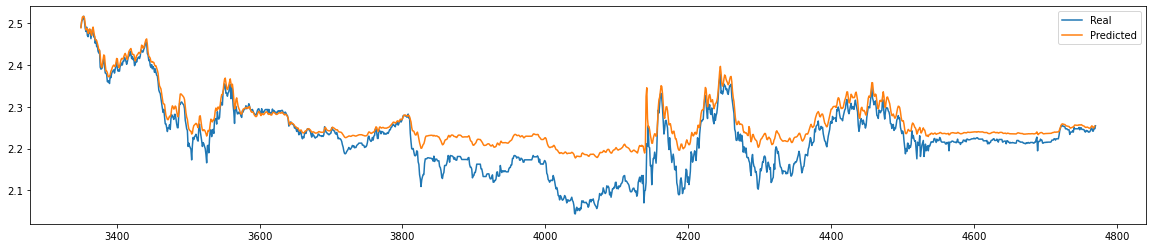

In [161]:
### This are the graphs before fixing the scaling issue.
''' DON'T RUN THIS CELL TO AVOID ERASE THE GRAPH'''
df.drop(columns=['close','close_predicted'])[3350:].plot(figsize=(20,4))

<AxesSubplot:>

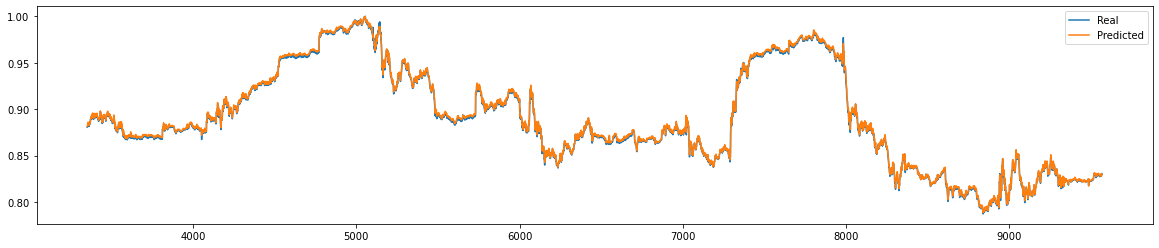

In [203]:
# The new graph with the scaler fixed
df.drop(columns=['close','close_predicted'])[3350:].plot(figsize=(20,4))

<AxesSubplot:>

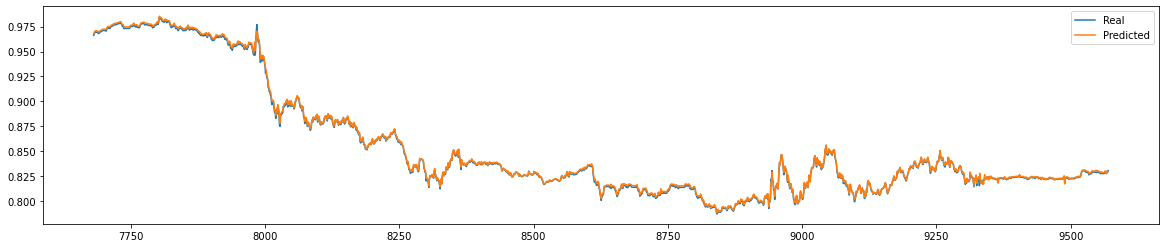

In [204]:
## The test area
df.drop(columns=['close','close_predicted'])[-1890:].plot(figsize=(20,4))

<AxesSubplot:>

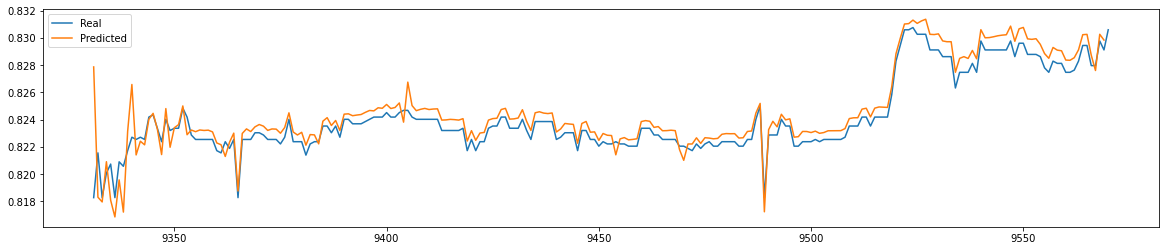

In [205]:
## The last 4 hours in the testing area
df.drop(columns=['close','close_predicted'])[-240:].plot(figsize=(20,4))

<AxesSubplot:>

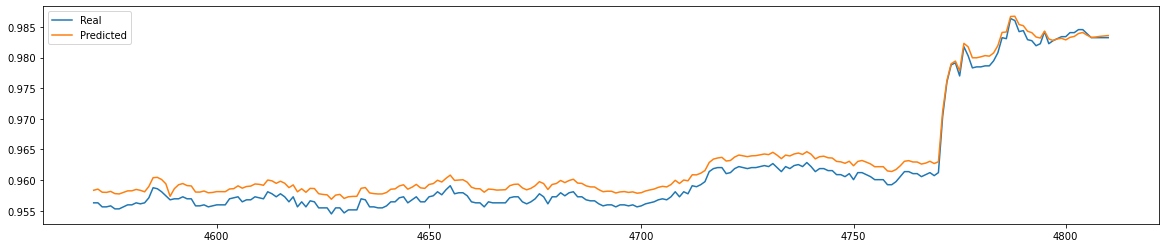

In [206]:
## The 4 hours in the middle of the training area
df.drop(columns=['close','close_predicted'])[-5000:-4760].plot(figsize=(20,4))

In [138]:
# There was a problem with the low data that was fixed with the change of scalers.

In [236]:
# Well now lets do the same with the 5 minutes and 30 minutes data ranges.
# Starting with 5 minutes data


def preparing_data(data, sma_name):

    dataset = data.copy()
    
    scaler_vol = StandardScaler()
    scaler_close = MinMaxScaler()

    dataset['volume'] = scaler_vol.fit_transform(np.array(dataset['volume']).reshape(-1,1))
    dataset['close'] = scaler_close.fit_transform(np.array(dataset['close']).reshape(-1,1))

    # Lets add the resulting column or the next minute price
    dataset['next_min'] = dataset['close'].shift(-1)
    # Guarantee we have all in float32 data type
    for col in dataset.columns:
        dataset[col] = dataset[col].astype('float32')

    dataset.drop(columns=sma_name, inplace=True)
    
    return dataset, scaler_vol, scaler_close

final_norm_5min, scale_vol, scale_close = preparing_data(final_set_5min, 'sma_24')

final_norm_5min

,market,close,volume,momentum,next_min
2021-04-12 08:00:00,-1.0,0.175908,-0.556085,-0.011507,0.175744
2021-04-12 08:05:00,-1.0,0.175744,-0.421202,-0.011350,0.171484
2021-04-12 08:10:00,-1.0,0.171484,-0.523489,-0.012325,0.171484
2021-04-12 08:15:00,-1.0,0.171484,-0.530553,-0.013017,0.170828
2021-04-12 08:20:00,-1.0,0.170828,-0.524630,-0.012986,0.170500
...,...,...,...,...,...
2021-12-17 19:40:00,1.0,0.830589,-0.578555,0.008943,0.828778
2021-12-17 19:45:00,1.0,0.828778,-0.572220,0.009818,0.828449
2021-12-17 19:50:00,1.0,0.828449,-0.576109,0.009331,0.830425
2021-12-17 19:55:00,1.0,0.830425,-0.576501,0.009549,0.831577


In [240]:
## The variables for 5 minutes
sequence_size = 24
test_size = 0.2
total_size = 4800
model_lstm_layers = 3
model_dropout = 0.3
second_lr = 0.001
changing_epoch = 150
batch_size = 64
model_input_size = 4
model_lstm_size = 128
model_output = 1
optimizer = 'Adam'
lr = 0.005
epochs = 200
second_lr = 0.001
changing_epoch = 150


In [241]:
## Lets create the training and testing data torchs
train_X, train_y, test_X, test_y = final_arrays(final_norm_5min, total_size, sequence_size, test_size, model_input_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

4800 4800 960 3840
(3816, 24, 4) (3816,) (937, 24, 4) (937,)
torch.Size([3816, 24, 4]) torch.Size([3816]) torch.Size([937, 24, 4]) torch.Size([937])


In [242]:
## Training the model
model_5min, losses_training_5min, losses_testing_5min = training_model(train_X, train_y, test_X, test_y, 
                                                        batch_size=batch_size, model_input_size=model_input_size, model_lstm_size=model_lstm_size,
                                                        model_lstm_layers=model_lstm_layers, model_output=model_output, model_dropout=model_dropout,
                                                        optimizer=optimizer, lr=lr, epochs=epochs, sequence_size=sequence_size,
                                                        lr_change=True, lr_top=second_lr, epochs_top=changing_epoch)

Optimizer: Adam, Leaning rate: 0.005
Epoch[10/200] | loss train:0.000708, test:0.000062, learning rate: 0.005
Epoch[20/200] | loss train:0.000509, test:0.000020, learning rate: 0.005
Epoch[30/200] | loss train:0.000413, test:0.000025, learning rate: 0.005
Epoch[40/200] | loss train:0.000229, test:0.000034, learning rate: 0.005
Epoch[50/200] | loss train:0.000140, test:0.000069, learning rate: 0.005
Epoch[60/200] | loss train:0.000128, test:0.000017, learning rate: 0.005
Epoch[70/200] | loss train:0.000092, test:0.000013, learning rate: 0.005
Epoch[80/200] | loss train:0.000077, test:0.000016, learning rate: 0.005
Epoch[90/200] | loss train:0.000091, test:0.000020, learning rate: 0.005
Epoch[100/200] | loss train:0.000079, test:0.000030, learning rate: 0.005
Epoch[110/200] | loss train:0.000083, test:0.000044, learning rate: 0.005
Epoch[120/200] | loss train:0.000072, test:0.000046, learning rate: 0.005
Epoch[130/200] | loss train:0.000078, test:0.000013, learning rate: 0.005
Epoch[140/

<AxesSubplot:>

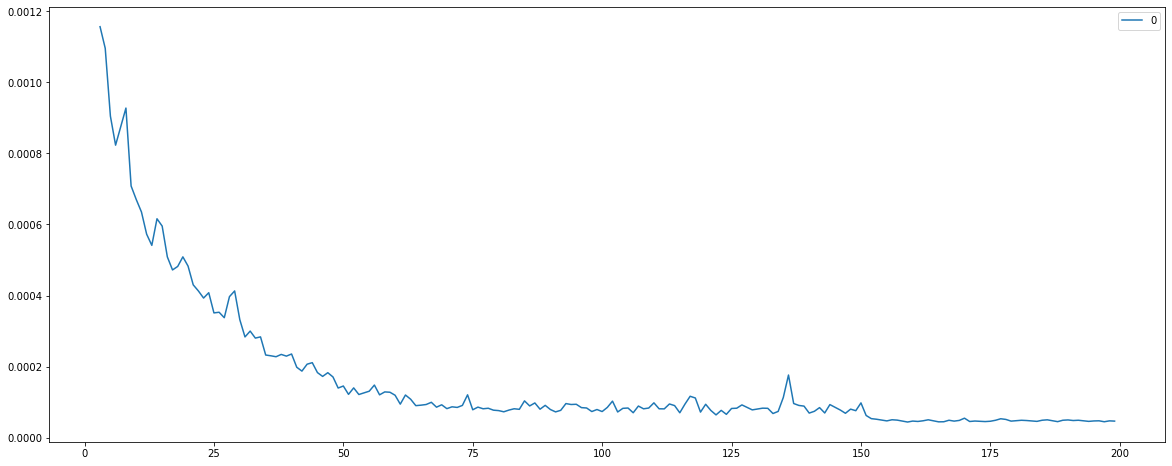

In [243]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_5min = pd.DataFrame(losses_training_5min)
graphs_Adam_5min.loc[3:].plot(figsize=(20,8))

<AxesSubplot:>

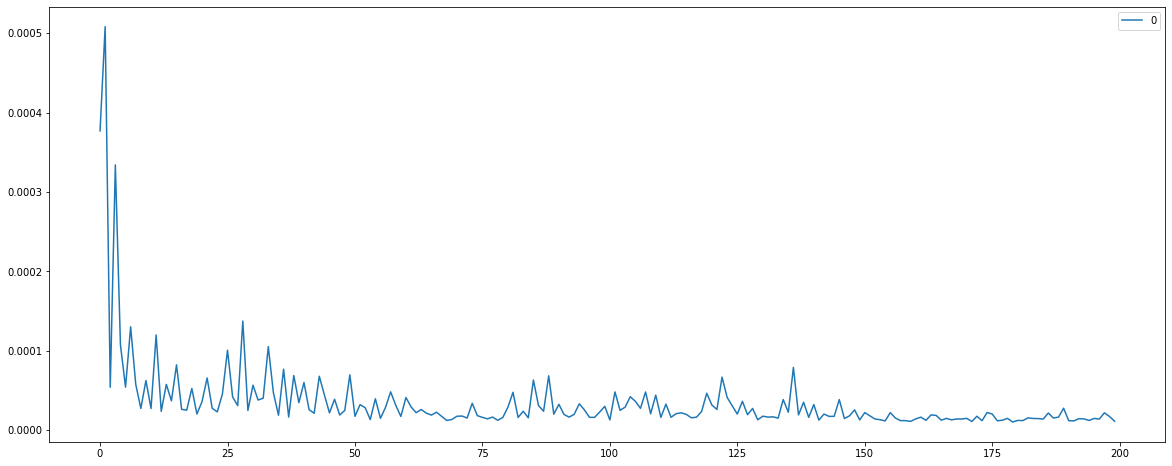

In [244]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_test_5min = pd.DataFrame(losses_testing_5min)
graphs_Adam_test_5min.loc[:].plot(figsize=(20,8))

In [245]:
### Saving the model
path = '/Users/carlosarocha/Dropbox/AI/GITHUB/UDACITY/TRADING_AI/My_Trading_Library/stock_predicting_model_5minute.dat'
torch.save(model_5min, path)

In [246]:
x_to_predict, y_to_predict = data_to_predict(final_norm_5min, total_size, sequence_size, model_input_size)
print(x_to_predict.shape, y_to_predict.shape)

predicting_series = Data_Prep(x_to_predict, y_to_predict)
# Restarting the dataloader with shuffle in False to have all the data in one sequence
dataloader_to_predict = DataLoader(predicting_series, batch_size=batch_size, shuffle=False)
# Now iterate for the data and check the predicted values
results = np.array([[],[]])
for x, y in dataloader_to_predict:
    y_predicted = model_5min(x)
    results = np.concatenate((results, np.array([y.detach().numpy(), y_predicted.detach().numpy()])), axis = 1)
    
df = pd.DataFrame(results.T, columns=['Real', 'Predicted'])
df['Predicted'] = df['Predicted'].shift(-1)

df['close'] = scale_close.inverse_transform(np.array(df['Real']).reshape(-1,1))
df['close_predicted'] = scale_close.inverse_transform(np.array(df['Predicted']).reshape(-1,1))

df

(4777, 24, 4) (4777,)


,Real,Predicted,close,close_predicted
0,0.439081,0.443710,148.050000,148.331193
1,0.439081,0.443788,148.050000,148.335901
2,0.439081,0.443827,148.050000,148.338300
3,0.439081,0.443886,148.050000,148.341887
4,0.439081,0.443886,148.050000,148.341889
...,...,...,...,...
4772,0.830589,0.830627,171.830001,171.832263
4773,0.828778,0.829230,171.720000,171.747457
4774,0.828449,0.828794,171.700001,171.720920
4775,0.830425,0.830542,171.820001,171.827097


<AxesSubplot:>

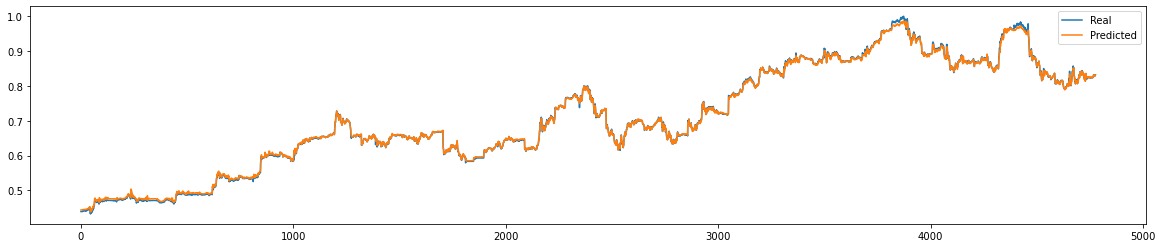

In [247]:
# The new graph with the scaler fixed
df.drop(columns=['close','close_predicted'])[:].plot(figsize=(20,4))

<AxesSubplot:>

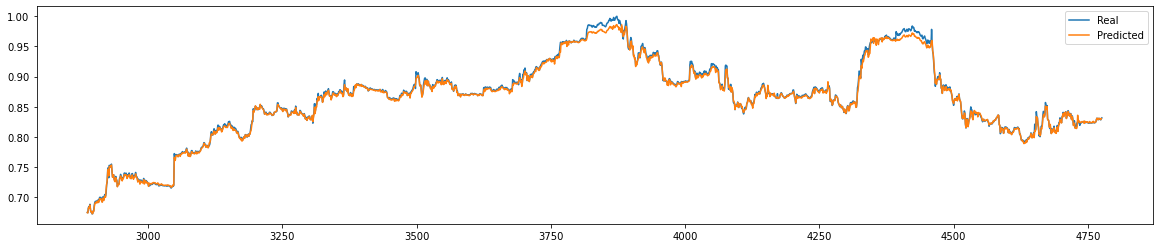

In [248]:
## The test area
df.drop(columns=['close','close_predicted'])[-1890:].plot(figsize=(20,4))

<AxesSubplot:>

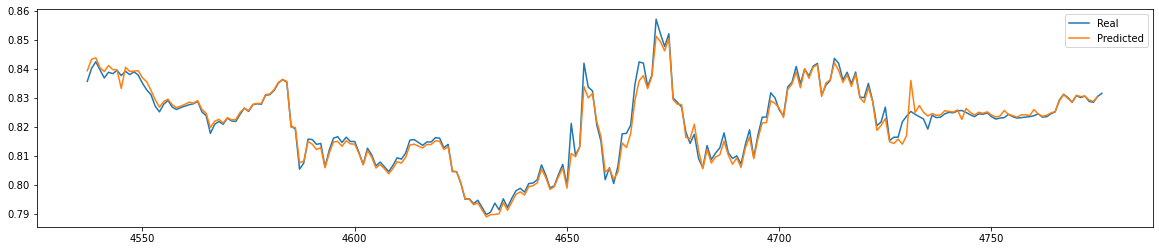

In [249]:
## The last 4 hours in the testing area
df.drop(columns=['close','close_predicted'])[-240:].plot(figsize=(20,4))

In [250]:
### Same process with 30 minutes:

final_norm_30min, scale_vol, scale_close = preparing_data(final_set_30min, 'sma_32')
final_norm_30min

,market,close,volume,momentum,next_min
2021-04-13 20:00:00,1.0,0.199866,-0.654434,0.096041,0.204485
2021-04-14 04:30:00,-1.0,0.204485,-0.673568,0.108078,0.207290
2021-04-14 05:00:00,-1.0,0.207290,-0.675159,0.121382,0.206135
2021-04-14 05:30:00,-1.0,0.206135,-0.675582,0.134281,0.207125
2021-04-14 06:00:00,-1.0,0.207125,-0.676736,0.146347,0.208115
...,...,...,...,...,...
2021-12-17 18:00:00,1.0,0.825957,-0.671888,-0.314955,0.826289
2021-12-17 18:30:00,1.0,0.826289,-0.576275,-0.298187,0.827449
2021-12-17 19:00:00,1.0,0.827449,-0.660689,-0.282466,0.833748
2021-12-17 19:30:00,1.0,0.833748,-0.672615,-0.267787,0.834576


In [309]:
## The variables for 5 minutes
sequence_size = 32
test_size = 0.1
total_size = 2400
model_lstm_layers = 3
model_dropout = 0.30
changing_epoch = 350
batch_size = 64
model_input_size = 4
model_lstm_size = 128
model_output = 1
optimizer = 'Adam'
lr = 0.001
epochs = 500
second_lr = 0.0005

In [310]:
## Lets create the training and testing data torchs
train_X, train_y, test_X, test_y = final_arrays(final_norm_30min, total_size, sequence_size, test_size, model_input_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

2400 2400 224 2176
(2144, 32, 4) (2144,) (193, 32, 4) (193,)
torch.Size([2144, 32, 4]) torch.Size([2144]) torch.Size([193, 32, 4]) torch.Size([193])


In [311]:
## Training the model
model_30min, losses_training_30min, losses_testing_30min = training_model(train_X, train_y, test_X, test_y, 
                                                        batch_size=batch_size, model_input_size=model_input_size, model_lstm_size=model_lstm_size,
                                                        model_lstm_layers=model_lstm_layers, model_output=model_output, model_dropout=model_dropout,
                                                        optimizer=optimizer, lr=lr, epochs=epochs, sequence_size=sequence_size,
                                                        lr_change=True, lr_top=second_lr, epochs_top=changing_epoch)

Optimizer: Adam, Leaning rate: 0.001
Epoch[10/500] | loss train:0.000622, test:0.001377, learning rate: 0.001
Epoch[20/500] | loss train:0.000395, test:0.005948, learning rate: 0.001
Epoch[30/500] | loss train:0.000349, test:0.000803, learning rate: 0.001
Epoch[40/500] | loss train:0.000258, test:0.000182, learning rate: 0.001
Epoch[50/500] | loss train:0.000236, test:0.002063, learning rate: 0.001
Epoch[60/500] | loss train:0.000236, test:0.000166, learning rate: 0.001
Epoch[70/500] | loss train:0.000222, test:0.000181, learning rate: 0.001
Epoch[80/500] | loss train:0.000188, test:0.000114, learning rate: 0.001
Epoch[90/500] | loss train:0.000158, test:0.000722, learning rate: 0.001
Epoch[100/500] | loss train:0.000148, test:0.000257, learning rate: 0.001
Epoch[110/500] | loss train:0.000144, test:0.000744, learning rate: 0.001
Epoch[120/500] | loss train:0.000144, test:0.000125, learning rate: 0.001
Epoch[130/500] | loss train:0.000120, test:0.000514, learning rate: 0.001
Epoch[140/

<AxesSubplot:>

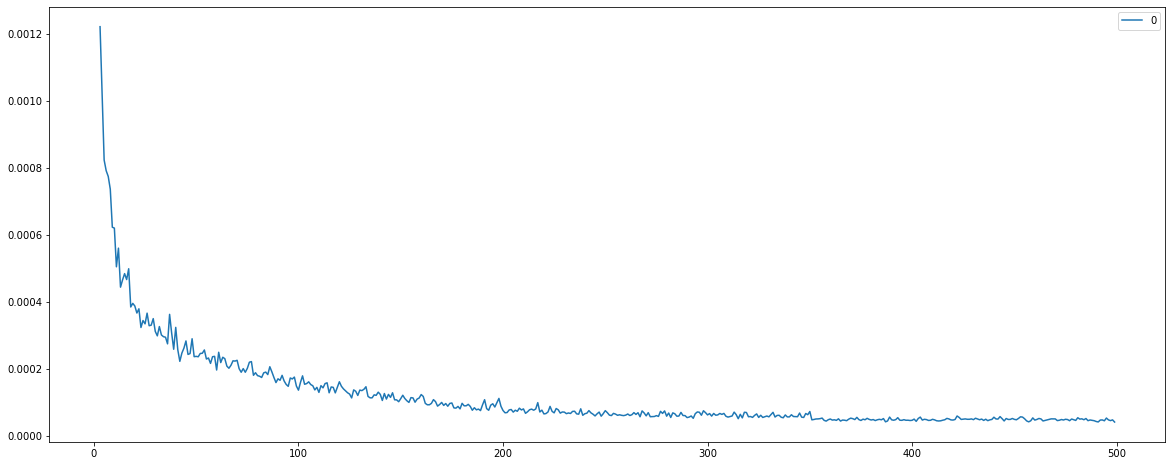

In [312]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_30min = pd.DataFrame(losses_training_30min)
graphs_Adam_30min.loc[3:].plot(figsize=(20,8))

<AxesSubplot:>

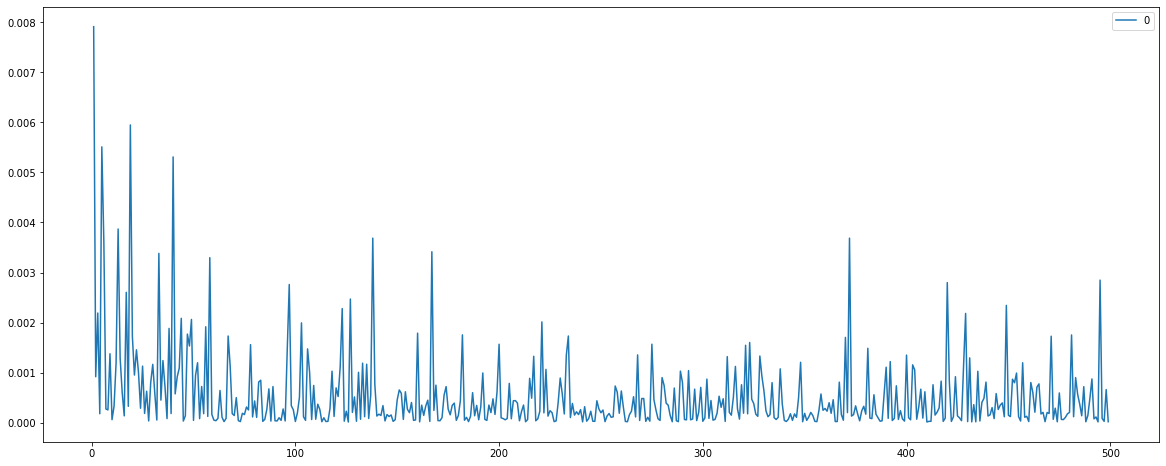

In [314]:
## Adam tests with 200 epochs and volume scaled as normal distribution and close prices as a linear normalization
## And learning rate reduced after 150 epochs.
graphs_Adam_test_30min = pd.DataFrame(losses_testing_30min)
graphs_Adam_test_30min.loc[1:].plot(figsize=(20,8))

In [315]:
### Saving the model
path = '/Users/carlosarocha/Dropbox/AI/GITHUB/UDACITY/TRADING_AI/My_Trading_Library/stock_predicting_model_30minute.dat'
torch.save(model_30min, path)

In [316]:
x_to_predict, y_to_predict = data_to_predict(final_norm_30min, total_size, sequence_size, model_input_size)
print(x_to_predict.shape, y_to_predict.shape)

predicting_series = Data_Prep(x_to_predict, y_to_predict)
# Restarting the dataloader with shuffle in False to have all the data in one sequence
dataloader_to_predict = DataLoader(predicting_series, batch_size=batch_size, shuffle=False)
# Now iterate for the data and check the predicted values
results = np.array([[],[]])
for x, y in dataloader_to_predict:
    y_predicted = model_30min(x)
    results = np.concatenate((results, np.array([y.detach().numpy(), y_predicted.detach().numpy()])), axis = 1)
    
df = pd.DataFrame(results.T, columns=['Real', 'Predicted'])
df['Predicted'] = df['Predicted'].shift(-1)

df['close'] = scale_close.inverse_transform(np.array(df['Real']).reshape(-1,1))
df['close_predicted'] = scale_close.inverse_transform(np.array(df['Predicted']).reshape(-1,1))

df

(2369, 32, 4) (2369,)


,Real,Predicted,close,close_predicted
0,0.527548,0.527886,153.366965,153.387394
1,0.534168,0.531147,153.766385,153.584092
2,0.534830,0.533434,153.806325,153.722079
3,0.533506,0.532298,153.726441,153.653555
4,0.532844,0.531589,153.686501,153.610756
...,...,...,...,...
2364,0.825957,0.798599,171.369999,169.719492
2365,0.826289,0.804733,171.390000,170.089526
2366,0.827449,0.803175,171.459999,169.995528
2367,0.833748,0.808829,171.840001,170.336632


<AxesSubplot:>

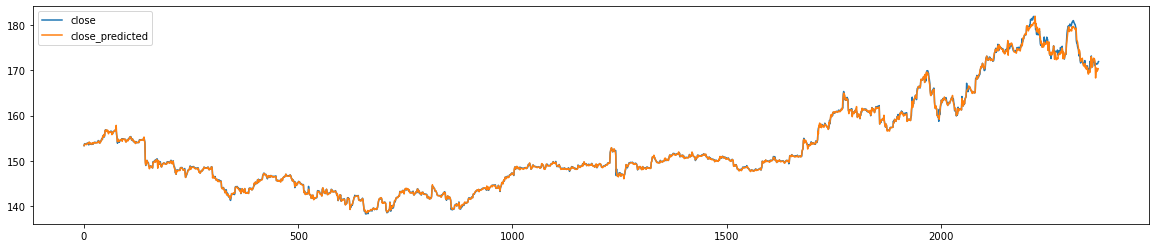

In [317]:
# The new graph with the scaler fixed
df.drop(columns=['Real','Predicted'])[:].plot(figsize=(20,4))

<AxesSubplot:>

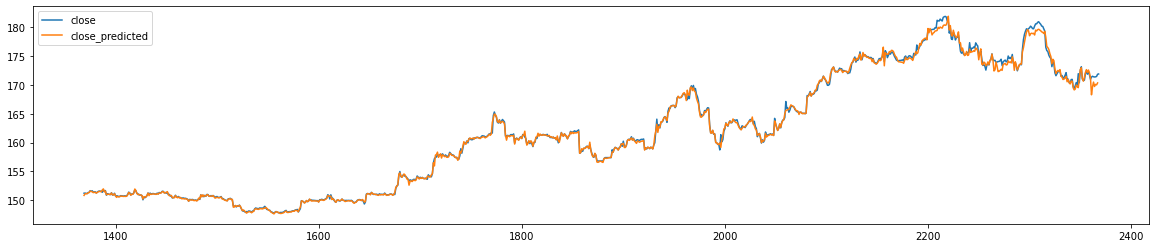

In [318]:
## The test area
df.drop(columns=['Real','Predicted'])[-1000:].plot(figsize=(20,4))

<AxesSubplot:>

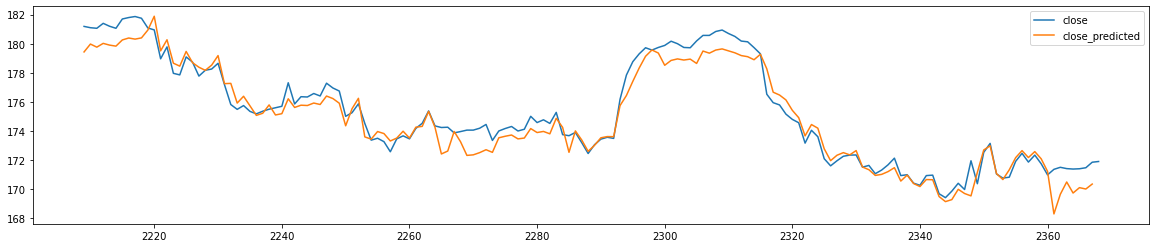

In [319]:
## The last 4 hours in the testing area
df.drop(columns=['Real','Predicted'])[-160:].plot(figsize=(20,4))